In [2]:
library(rmarkdown)
library(knitr)
library(xfun)
library(egg)

#This is necassary to be able to build a R source file using jupyter notebook
#This chunck of code will remove the html code added by jupyter notebook and create a pure
#R source code file. Therefore you can use jupyter notebook to build your R source code file containing
# function definitions. 
Rsource="functionDef_ScientificReports.ipynb"
convert_ipynb(Rsource)
purl(with_ext(Rsource, "Rmd"), output = with_ext(Rsource, "R"))
file.remove(with_ext(Rsource, "Rmd"))

source("functionDef_ScientificReports.R")

##A command to increase the number of rows that will be printed when displaying data in the notebook
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)




processing file: functionDef_ScientificReports.Rmd



1/5                  
2/5 [unnamed-chunk-1]
3/5                  
4/5 [unnamed-chunk-2]
5/5                  


output file: functionDef_ScientificReports.R




[1] "functionDef_ScientificReports.R"

[1] TRUE

In [3]:
####Additional function definitions


#####Given a data frame in the data format in which metadata columns contain metadata in the column name
##### and the columns that contain data the column name is the name of the biomarker being meaasure
#####produce a violin plot of the data grouping together by disease status this function is designed to 
####plot normalized data not Ct values


plotViolinPlots_normalized<-function(data_long, mainTitle="", ylab="Ct value", dataColumn=3, 
                         ylabBarPlot=c("Fraction of\nSamples with\n Detectable Expression"),
                         ylabScatterPlot=c("Ct Values\nSamples With Detectable\nExpression"), topLeftLabel=""){
    
data_col_name=colnames(data_long)[dataColumn]



#add another column indicating if data falls below the detection limit
    data_long$detection_limit=rep(TRUE, nrow(data_long))
    
     data_long$detection_limit[which(data_long[, dataColumn]==40)]=FALSE


    
#only plotting points on the violin plot that have been detected
    data_long_above_limit=data_long[which(data_long$detection_limit), ]


    ##Setting the size of the plot
     options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)


###Plot each point
    plot1=ggplot(data_long_above_limit, aes(x=Genes, y=.data[[data_col_name]], color=Sample_Type))+geom_boxplot(lwd=0.5, outlier.size = 0.3)+
    geom_point(position = position_jitterdodge(seed = 1, dodge.width = 0.6,  jitter.width=0.1), size=0.3, 
                           aes(color=Sample_Type))+theme_pubr()+theme(text = element_text(size=9), 
                                                          axis.title.x=element_blank(), axis.text.x=element_blank(),
                                                          axis.ticks.x=element_blank(),
                                                          plot.margin = unit(c(0.1,0.1,0,0.1), "cm"),
                                                                        axis.line.x = element_blank(),  
                                                                      legend.title = element_text(size=7), 
                                                                      legend.text = element_text(size=6))


             
    ###Adding a plot title
    plot1=plot1+ggtitle(mainTitle)+theme(plot.title = element_text(hjust = 0.5))

    ####Setting the y axis to be fixed. This is done for the manuscript
    plot1=plot1+ylim(-6,5.5)
    
  

     #getting the fraction of samples above the limit of detection
    df_fraction_above_detection=data_long %>% group_by(Genes,Sample_Type
                                               ) %>% summarize(Fraction_Samples_Detected=length(which(detection_limit==TRUE))/
                                                               length(detection_limit))

    
     print(df_fraction_above_detection)



    ## bar plot representing the fraction of samples below the limit of detection
    plot2=ggplot(df_fraction_above_detection, aes(x=Genes, y=Fraction_Samples_Detected, fill=Sample_Type)
            )+geom_bar(stat="identity", position=position_dodge(), width = 0.6)+theme_pubr()+theme(text = element_text(size=9), 
                                                                            axis.text.x = 
                                                                             element_text(angle = 90, vjust = 0.5, 
                                                                                      hjust=1, size=8), 
                                                                            axis.text.y = 
                                                                             element_text(size=9), 
                                                                                     legend.position = "none",
                                                                                                   panel.border = element_rect(colour = "black", fill=NA, size=0.6))
    plot2=plot2+scale_y_continuous( limits = c(0, 1))+labs(y=ylabBarPlot)

    plot1=plot1+labs(y= ylabScatterPlot)

    
    return(plot1/plot2+plot_layout(heights=c(3,1)))

}



plotBoxPlots<-function(data_long, mainTitle="", ylab="Age", dataColumn=3, 
                         colorColumn="Sample_Type"
                         ){


       ##Getting the name of the data column
    data_col_name=colnames(data_long)[dataColumn]



    maxValue=max(data_long[, dataColumn])
    minValue=min(data_long[, dataColumn])

  
    


   
    
  

    #construct violin plot
    plot1=ggplot(data_long, aes(x=.data[[colorColumn]], y=.data[[data_col_name]], color=.data[[colorColumn]]))+geom_boxplot(lwd=3)+
    geom_point(position = position_jitterdodge(seed = 1, dodge.width = 0.6,  jitter.width=0.1), size=6, 
                           aes(color=.data[[colorColumn]]))+theme_pubr()+theme(text = element_text(size=45), axis.text.x = 
                                                                             element_text(angle = 90, vjust = 0.5, 
                                                                                      hjust=1, size=45), axis.title.x = element_text(margin = margin(t = 30))) #+coord_cartesian(ylim=c(minValue-0.1, maxValue+0.2))

    plot1=plot1+theme(legend.text = element_text(size=30), legend.title=element_text(size=30), legend.key.width = unit(5, 'cm') )

  
    

    plot1=plot1+ggtitle(mainTitle)

     return(plot1)

   
}






In [4]:
#Read in paper raw PCR data as well as previous TCGA RNA-seq tissue based analysis results


##Reading in results of data analysis which generated the genes to screen in POC1. This code has 
##been reviewed and place in github. The results of the analysis are also in gitHub and I am reading them
###in here
high_expression_CRC=read.table(file="Data/highCRC_GeneList.tsv", 
                               sep="\t", as.is=TRUE, header=TRUE)
low_background_normal=read.table(file="Data/lowBackground_GeneList.tsv", 
                              sep="\t", as.is=TRUE, header=TRUE)

#Load the PCR data obtained from stool for the paper 
#All_Genes_data=read.table(file="/home/loren/Projects/CRC/GGDRepo/ggdx/projects/crc/Paper_analysis/Data/Paper_Experiment_raw_data.csv", 
 #as.is=TRUE, sep=",", header=TRUE)

All_Genes_data=read.table(file="Data/Paper_Experiment_Supplemental_data_table.csv", 
                          as.is=TRUE, sep=",", header=TRUE)

##Reading in CPM data for each of the TCGA and GTEX samples this is for plotting purposes. 
cpm_Counts=read.table(file="Data/TCGA_GTEX_cpm_adjusted_counts_Data_table.csv", 
                          as.is=TRUE, sep=",", header=TRUE)

#Read in TCGA data analysis results
TCGA_Gtex_results=read.csv(file="Data/TCGA_Gtex_results.csv", as.is=TRUE)


#Read in the code translating RB* code names to gene names our collaborators did not use gene names but gene codes that were internal to them. 
Code_to_Gene=read.csv(file="Data/Code_corresponding_to_the_gene-20240227.tsv", 
                      as.is=TRUE, sep="\t")




head(high_expression_CRC)
head(low_background_normal)


,ensemID,logFC,logCPM,LR,PValue,FDR,T_perc,N_perc,T_median,N_median,AUC,Metric_FC,Metric_FC_CPM,Gene,N_percentile,T_percentile
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,ENSG00000120708,3.229163,9.273145,2104.885,0,0,1,1.0000000,1083.0503,117.851142,0.9016782,3.229163,29.94450,TGFBI,0.9103515,0.9965173
2,ENSG00000124614,3.647234,7.181568,4397.560,0,0,1,1.0000000,157.1246,24.006493,0.9540547,3.647234,26.19286,RPS10,0.5404063,0.9451145
3,ENSG00000103888,5.261627,6.188737,8956.293,0,0,1,0.9467626,142.5684,2.511497,0.9846287,5.557181,34.39193,CEMIP,0.1985811,0.9361496
4,ENSG00000101187,3.518322,6.266389,4590.086,0,0,1,1.0000000,140.3977,12.172762,0.9423061,3.518322,22.04718,SLCO4A1,0.3935505,0.9344728
5,ENSG00000099953,4.389035,6.436683,6625.174,0,0,1,0.9942446,137.6851,7.844560,0.9566645,4.414416,28.41420,MMP11,0.3230571,0.9325379
6,ENSG00000130513,3.250709,6.353840,3974.562,0,0,1,0.9525180,130.0029,7.951711,0.9105837,3.412584,21.68301,GDF15,0.3252499,0.9260884


,ensemID,logFC,logCPM,LR,PValue,FDR,T_perc,N_perc,T_median,N_median,AUC,Metric_FC,Metric_FC_CPM,Gene,N_percentile,T_percentile
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,ENSG00000159263,8.039920,5.346465,15550.516,0,0,0.9916318,0.008633094,95.38619,0.36426702,0.9896015,828.46495,4429.35893,SIM2,0.06107707,0.8827475
2,ENSG00000149968,4.109755,5.765311,5957.527,0,0,0.9979079,0.371223022,78.91943,0.29451300,0.9375365,11.02905,63.58592,MMP3,0.05256369,0.8478555
3,ENSG00000060718,6.461182,5.631467,11942.995,0,0,1.0000000,0.480575540,77.50436,0.93699695,0.9926613,13.43017,75.63157,COL11A1,0.11944534,0.8442438
4,ENSG00000062038,6.006978,4.955926,9622.931,0,0,1.0000000,0.397122302,71.92273,0.84897987,0.9920231,15.10336,74.85114,CDH3,0.11299581,0.8276040
5,ENSG00000196611,4.490617,5.689420,6862.273,0,0,1.0000000,0.250359712,70.92722,0.02911157,0.9585789,17.88317,101.74484,MMP1,0.01534989,0.8239278
6,ENSG00000164379,6.266172,4.956024,10235.024,0,0,0.9874477,0.297841727,65.89261,0.58095105,0.9809021,20.72597,102.71839,FOXQ1,0.08758465,0.8075460


In [5]:
#Look at summary statistics for each patient group

summary_Age=All_Genes_data %>%
  group_by(Sample.type) %>%
  summarize(mean_value = mean(Age), .groups = "drop")


min_Age=All_Genes_data %>%
  group_by(Sample.type) %>%
  summarize(min_value = min(Age), .groups = "drop")


summary_Gender=All_Genes_data %>%
  group_by(Sample.type) %>%
  summarize(gender = table(Gender), .groups = "drop")

summary_Age

summary_Gender

min_Age


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”


Sample.type,mean_value
<chr>,<dbl>
AA,47.71429
CON,60.65714
CRC,64.45455
Col_Neg,53.38889


Sample.type gender <NA>
1 AA          Female  7  
2 AA          Male   21  
3 CON         Female 15  
4 CON         Male   20  
5 CRC         Female 11  
6 CRC         Male   22  
7 Col_Neg     Female 11  
8 Col_Neg     Male    7

Sample.type,min_value
<chr>,<int>
AA,30
CON,38
CRC,48
Col_Neg,41


In [6]:
###Cleaning up the PCR input data and enforcing consistent labeling

#removing the period that is present after many of the column names the periods are likely an artifact of R
#not liking certain characters in column names and changing them automaticaly when reading in data

colnames(All_Genes_data)=gsub("\\.*$","", colnames(All_Genes_data))
 

#replacing / which means no signal was detected with 40 which is the maximum PCR cycle number. 
All_Genes_data[All_Genes_data == "/"] <- 40




#Get the list of genes with only one value for every sample this 
#represents genes with only 40 for every sample i.e. no signal for all samples
noSignalIndexes=which(apply(All_Genes_data, 2, function(a) length(unique(a))==1))

if(length(noSignalIndexes) > 0){                                
#remove the genes with no signal in all samples
All_Genes_data=All_Genes_data[, -noSignalIndexes]

}

#getting column indexes that correspond to the genes getting tested
#genesTested=grep("^RB|GAPDH|MMP11", colnames(All_Genes_data))

genesTested=7:ncol(All_Genes_data)
                      
                                
#removing from the colnames the RB code for colnames that look like this: RB019.ETV4 converting 
#it to look like this: ETV4
colnames(All_Genes_data)=gsub("^RB.*\\.","", colnames(All_Genes_data))

                              
                            
#converting gene data to numeric
All_Genes_data <- All_Genes_data %>% mutate_at(genesTested, as.numeric)


                            
#converting from code names to gene names
allColNames=colnames(All_Genes_data)                
mappedGenes=mapvalues(allColNames, Code_to_Gene$Code, Code_to_Gene$Gene)
colnames(All_Genes_data)=mappedGenes

##Setting the column name containing the sample diagnosis to be conistent with other analysis done
colnames(All_Genes_data)[2]="Sample_Type"

head(All_Genes_data)

The following `from` values were not present in `x`: RB001, RB002, RB003, RB004, RB005, RB006, RB007, RB008, RB009, RB010, RB011, RB012, RB013, RB014, RB015, RB016, RB017, RB018, RB019, RB020, RB021, RB022, RB023, RB024, RB025, RB026, RB027, RB028, RB029, RB030, RB031, RB032, RB033, RB034, RB035, RB036, RB037, RB038, RB039, RB040, RB041, RB042, RB043, RB044, RB045, RB046, RB047, RB048, RB049, RB050, RB051, RB052, RB053, RB054, RB055, RB056, RB057, RB058, RB059, RB060, RB061, RB062, RB063, RB064, RB065, RB066, RB067, RB068, RB069, RB070, RB071, RB072, RB073, RB074, RB075, RB076, RB077, RB078, RB079, RB080, RB081, RB082, RB083, RB084, RB085, RB086, RB087, RB088, RB089, RB090, RB091, RB092, RB093, RB094, RB095, RB096, RB097, RB098, RB099, RB100, RB101, RB102, RB103, RB104, RB105, RB106, RB107, RB108, RB109, RB110, RB111, RB112, RB113, RB114, RB115, RB116, RB117, RB118, RB119, RB120, RB121, RB122, RB123, RB124, RB125, RB126, RB127, RB128, RB129, RB130, RB131, RB132, RB133, RB134, RB135, RB

,Sample.No,Sample_Type,Pathological.diagnosis,Stage,Gender,Age,GAPDH,TGFBI,RPS10,CEMIP,SLCO4A1,MMP11,GDF15,ETV4,NME2,COL11A1,TRIB3,SIM2,MMP3,MMP1,CXCL8,REG1A,KRT80,CEL,COMP,DPEP1,CPNE7
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,456,CRC,moderately differentiated adenocarcinoma of the rectum,III,Male,68,23.68,28.26,31.79,31.60,33.20,37.22,25.50,31.32,28.55,40,28.89,33.86,28.65,27.80,18.50,31.40,35.22,27.44,35.07,28.36,30.23
2,503,CRC,Moderately differentiated adenocarcinoma of sigmoid colon,I,Female,66,25.78,30.91,34.58,35.53,40.00,37.42,28.43,33.23,31.72,40,31.33,36.79,40.00,31.12,23.54,34.88,37.02,33.56,40.00,40.00,31.86
3,532,CRC,moderately differentiated adenocarcinoma of the rectum,III,Female,68,32.53,36.26,35.71,40.00,40.00,40.00,40.00,40.00,33.32,40,40.00,38.01,40.00,40.00,33.67,35.37,33.84,33.58,40.00,40.00,36.86
4,533,CRC,Rectal protuberance moderately differentiated adenocarcinoma,III,Male,60,26.35,28.89,33.30,31.23,34.00,35.02,27.77,30.89,30.05,40,30.02,40.00,31.61,31.00,22.94,30.28,33.54,31.89,40.00,30.31,28.73
5,534,CRC,Infiltrating ulcerative poorly differentiated adenocarcinoma of the rectum,I,Female,74,26.43,32.97,35.44,33.42,36.57,40.00,28.37,32.96,29.20,40,29.62,31.54,40.00,32.91,20.55,31.58,31.36,34.10,40.00,40.00,30.63
6,535,CRC,Infiltrating ulcerative moderately differentiated adenocarcinoma of the rectum,II,Male,65,27.21,36.66,34.97,40.00,38.13,40.00,30.91,40.00,33.36,40,40.00,38.12,40.00,37.48,29.61,35.51,35.97,35.97,40.00,35.91,40.00


In [7]:
#######Normalizing PCR data 

#select control samples that will be used as the reference samples. 
refIndexes=which(All_Genes_data$Sample_Type %in% c("CRC"))


foldExpression_wide=deltaDeltaCTCalculation(All_Genes_data, geneNames=colnames(All_Genes_data)[genesTested], normalizationGene="GAPDH", 
                             refIndexes, useCancer=FALSE)

#setting samples with undetected expression to a normalized value of 0
foldExpression_wide[is.na(foldExpression_wide)]=0

head(foldExpression_wide)

#Saving normalized results to a file 
write.table(x=foldExpression_wide, file="Data/top_20_genes_normalized_PCR_data.csv",
           row.names=FALSE, sep=",", quote=FALSE)

#saving raw Cts to a file
rawData=cbind("Sample_Type"=All_Genes_data[, c("Sample_Type")], All_Genes_data[, genesTested])

write.table(x=rawData, file="Data/top_20_genes_rawCT_PCR_data.csv",
           row.names=FALSE, sep=",", quote=FALSE)

,Sample_Type,GAPDH,TGFBI,RPS10,CEMIP,SLCO4A1,MMP11,GDF15,ETV4,NME2,COL11A1,TRIB3,SIM2,MMP3,MMP1,CXCL8,REG1A,KRT80,CEL,COMP,DPEP1,CPNE7
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CRC,1,1.46408570,0.8066418,0.5664419,2.639016,0.1855654,1.2613774,0.5783441,0.4444213,0,1.404445,0.7578583,1.790050,2.32946717,11.00433455,0.21613431,0.05632815,27.8576180,1.068065,2.1734697,2.557971
2,CRC,1,1.00000000,0.5000000,0.1593201,0.000000,0.6925547,0.7095617,0.6597540,0.2116863,0,1.109569,0.4263174,0.000000,1.00000000,1.43395525,0.08304286,0.06934809,1.7171309,0.000000,0.0000000,3.543070
3,CRC,1,2.63901582,24.5900029,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,7.5161820,0,0.000000,19.6983106,0.000000,0.00000000,0.13773814,6.36429187,67.64915460,182.2784250,0.000000,0.0000000,11.917420
4,CRC,1,6.02098699,1.8025009,4.6589343,9.646463,5.4264173,1.6643975,4.9588308,1.0000000,0,4.084049,0.0000000,1.464086,1.61328352,3.22656704,2.98969850,1.14869835,8.1116758,0.000000,3.5801003,46.045875
5,CRC,1,0.37631169,0.4322686,1.0792282,1.717131,0.0000000,1.1607039,1.2483305,1.9052760,0,5.696201,25.4571675,0.000000,0.45375958,17.87659421,1.28342590,5.50216727,1.8531761,0.000000,0.0000000,13.041157
6,CRC,1,0.05006687,1.0281138,0.0000000,1.000000,0.0000000,0.3426957,0.0000000,0.1830107,0,0.000000,0.4569157,0.000000,0.03280365,0.05751173,0.14458602,0.38689125,0.8705506,0.000000,0.1339717,0.000000


In [8]:
#converting to long format both normalized and unnormalized data 

#normalized data convert to long
foldExpression_long=gather(foldExpression_wide, Genes, foldExpression, 2:ncol(foldExpression_wide),
                           factor_key=TRUE)


#raw CT values convert to long format this is necassary for most ggplot plotting functions
rawData=cbind("Sample_Type"=All_Genes_data[, c("Sample_Type")], All_Genes_data[, genesTested])

rawCT_long=gather(rawData, Genes, Ct, 2:ncol(rawData), factor_key=TRUE)



##Getting age and gender in long format suitable for plotting 
rawData=cbind("Sample_Type"=All_Genes_data[, c("Sample_Type")], "Age"=All_Genes_data[, c("Age")], "Gender"=All_Genes_data[, c("Gender")], All_Genes_data[, genesTested])

Age_long=gather(rawData, Genes, Ct, 4:ncol(rawData), factor_key=TRUE)

head(Age_long)


#removing any rows with NAs
foldExpression_long=na.omit(foldExpression_long)
rawCT_long=na.omit(rawCT_long)




#log transforming the fold expression change to make visualization easier
temp=log(foldExpression_long$foldExpression)

Log_Fold_Expression_long=foldExpression_long

Log_Fold_Expression_long$foldExpression=temp

colnames(Log_Fold_Expression_long)[3]="Log_Fold_Expression"
colnames(rawCT_long)[1]="Sample_Type"


#creating a data structure setting the normalized values to 40 for those samples which had undetectable signal
indexes=which(rawCT_long$Ct==40)


Log_Fold_Expression_long_Undetectable_set_40=Log_Fold_Expression_long
Log_Fold_Expression_long_Undetectable_set_40[indexes, "Log_Fold_Expression"]=40


foldExpression_long_Undetectable_set_0=foldExpression_long
foldExpression_long_Undetectable_set_0[indexes, "foldExpression"]=0


head(rawCT_long)


#Saving long format to a file 
write.table(x=Log_Fold_Expression_long_Undetectable_set_40, file="Data/top_20_normalized_PCR_long_format_data.csv",
           row.names=FALSE, sep=",", quote=FALSE)

write.table(x=rawCT_long, file="Data/top_20_rawCt_PCR_long_format_data.csv",
           row.names=FALSE, sep=",", quote=FALSE)


,Sample_Type,Age,Gender,Genes,Ct
,<chr>,<int>,<chr>,<fct>,<dbl>
1,CRC,68,Male,GAPDH,23.68
2,CRC,66,Female,GAPDH,25.78
3,CRC,68,Female,GAPDH,32.53
4,CRC,60,Male,GAPDH,26.35
5,CRC,74,Female,GAPDH,26.43
6,CRC,65,Male,GAPDH,27.21


,Sample_Type,Genes,Ct
,<chr>,<fct>,<dbl>
1,CRC,GAPDH,23.68
2,CRC,GAPDH,25.78
3,CRC,GAPDH,32.53
4,CRC,GAPDH,26.35
5,CRC,GAPDH,26.43
6,CRC,GAPDH,27.21


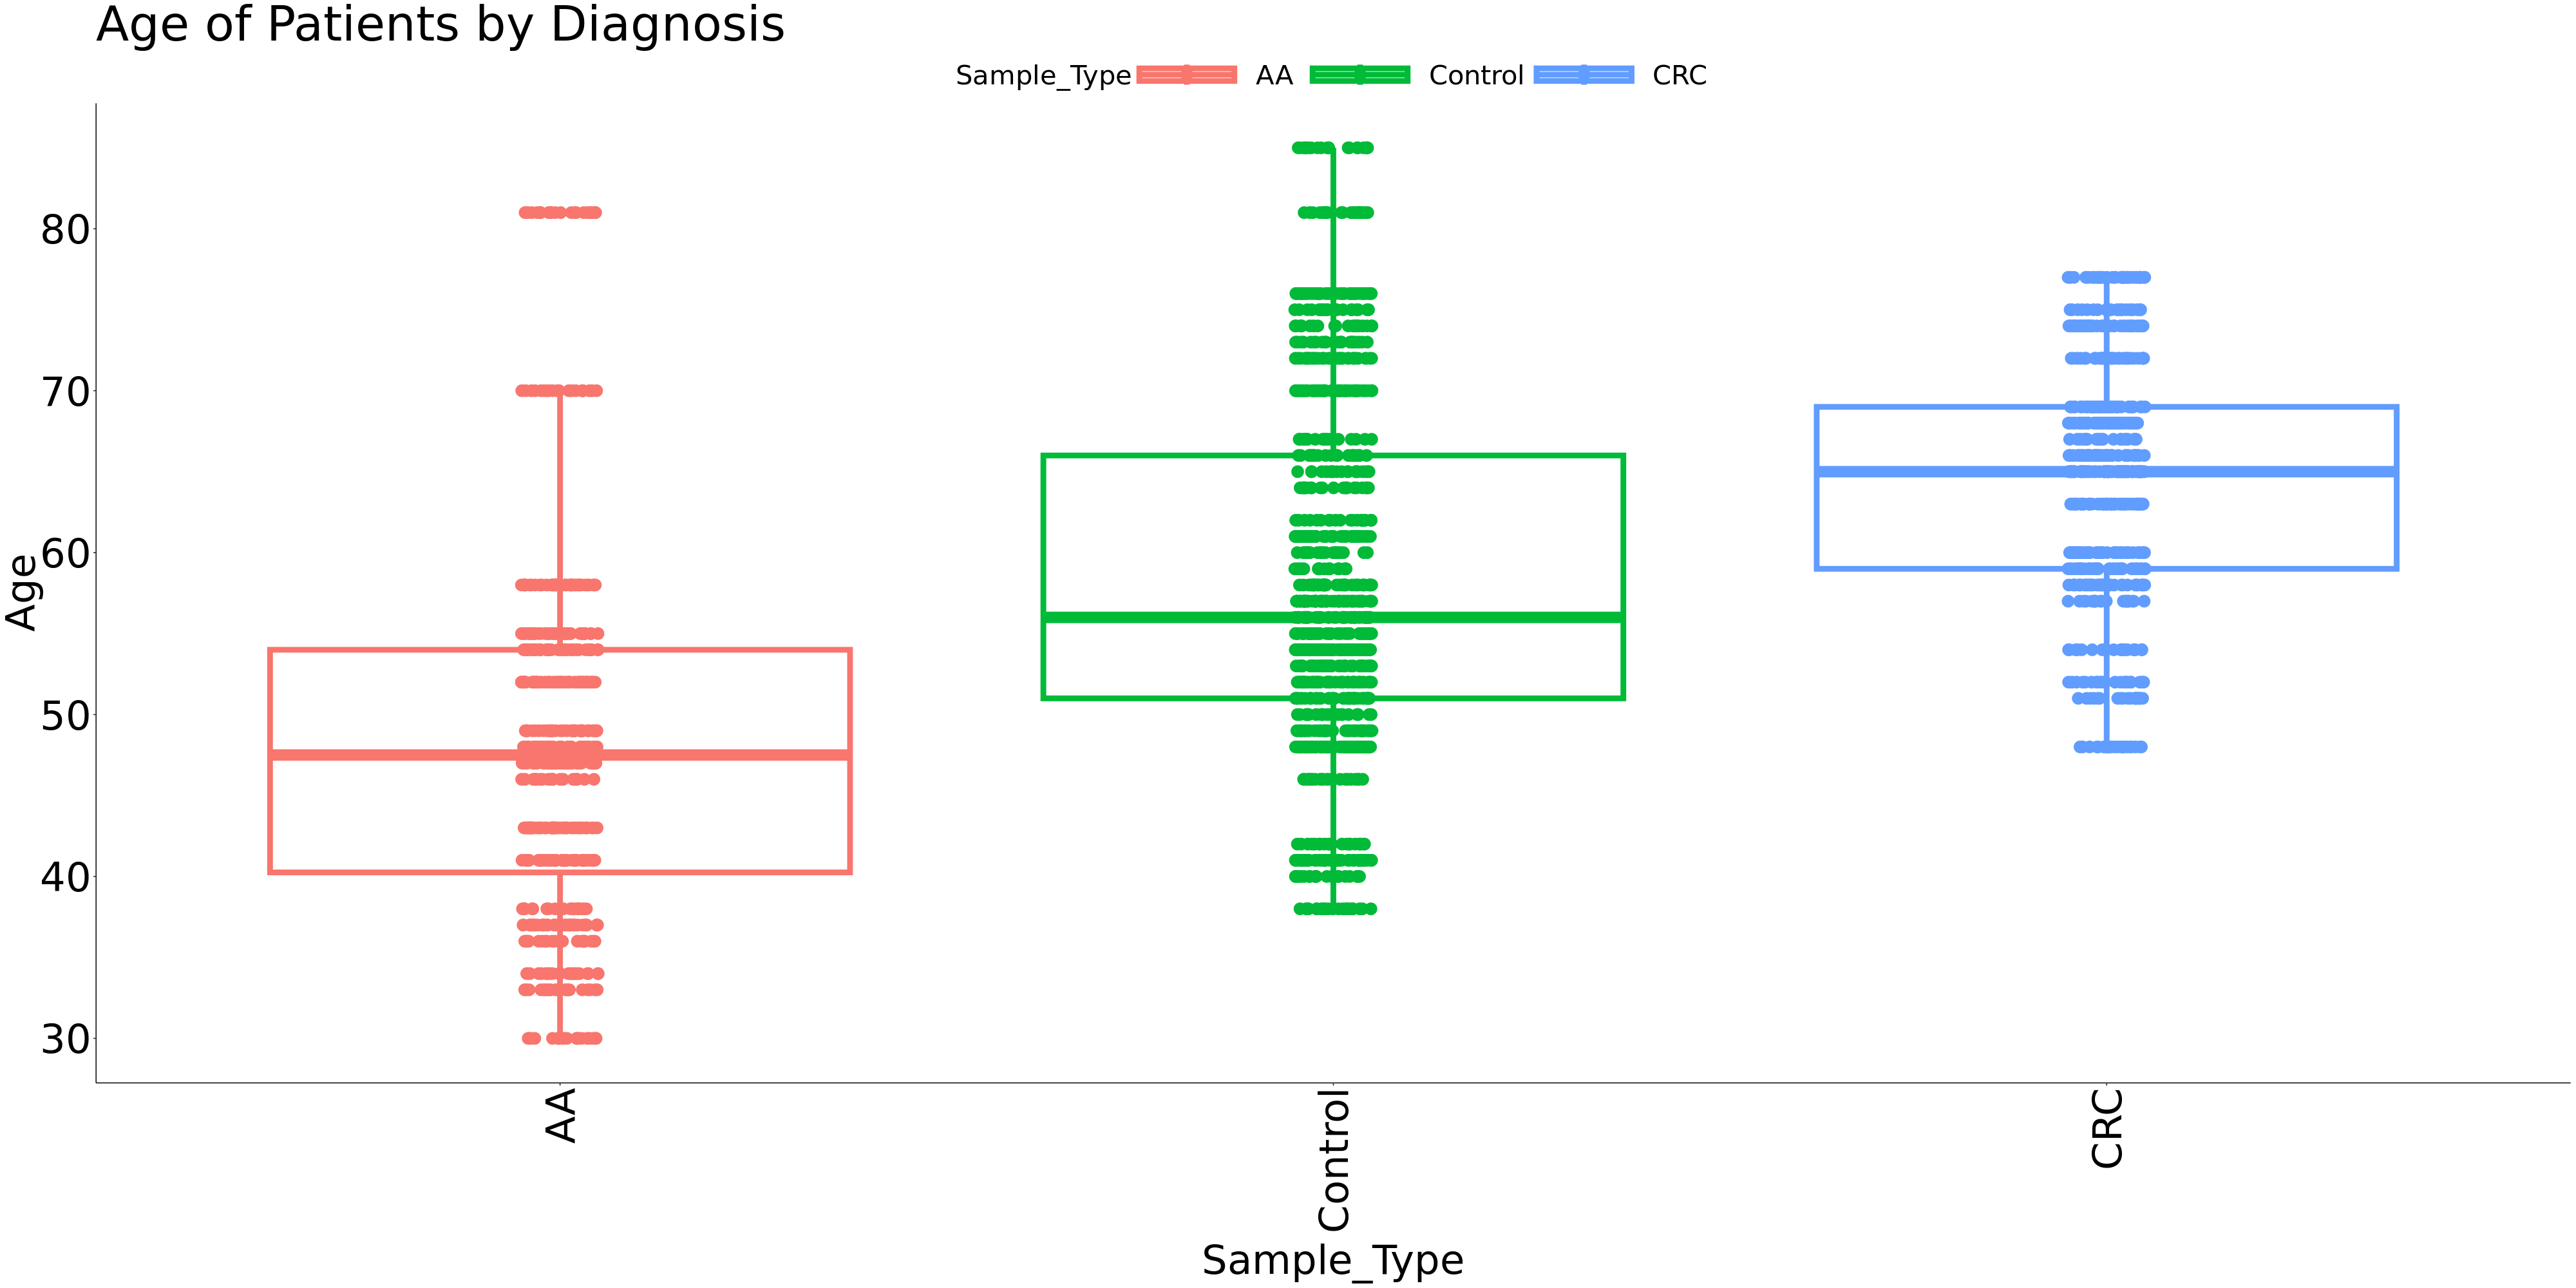

In [9]:


options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)

dataSet=Age_long

#merging the colonoscopy negatve and healthy volunteers into a singel control group

temp=which(dataSet$Sample_Type %in% c("Col_Neg", "CON"))

dataSet$Sample_Type[temp]="Control"

plot=plotBoxPlots(dataSet, mainTitle="Age of Patients by Diagnosis", ylab="TPM", dataColumn=2, 
                         colorColumn="Sample_Type")

print(plot)


plot=plotBoxPlots(dataSet, mainTitle="Age of Patients by Diagnosis", ylab="TPM", dataColumn=2, 
                         colorColumn="Sample_Type")




In [10]:
##########Getting Table 1 data


#Some of these genes have only one exon so RNA specific primers/probes cannot be designed for them
#These genes must be discarded and this was done by manually checking of the top ranked genes which have only one exon
#Final top ten genes for each list

top_high_CRC_list=c("TGFBI",  "RPS10",  "CEMIP", "SLCO4A1", 
           "MMP11",  "GDF15", "ETV4",  "NME2", "COL11A1",  "TRIB3")

top_low_background_list=c("SIM2", "MMP3", "MMP1", "CXCL8", 
                     "REG1A",  "KRT80", "CEL", "COMP", "DPEP1",  "CPNE7")


####Get metrics from tissue for these genes this will be data presented in Table 1. 
top_high_data=filter(high_expression_CRC, Gene %in% top_high_CRC_list)
top_low_data=filter(high_expression_CRC, Gene %in% top_low_background_list)


head(top_high_data)
(top_high_data[, c("AUC", "N_percentile", "T_percentile")])
(top_low_data[, c("AUC", "N_percentile", "T_percentile")])


#Print the key tissue results for easy import into a table

write.table(x=top_high_data[, c("Gene", "logFC", "FDR", "AUC", "N_percentile", "T_percentile")], file="Results/top_high_tissue_metrics.csv",
           row.names=FALSE, sep=",", quote=FALSE)


write.table(x=top_low_data[, c("Gene", "logFC", "FDR", "AUC", "N_percentile", "T_percentile")], file="Results/top_low_background_tissue_metrics.csv",
           row.names=FALSE, sep=",", quote=FALSE)


,ensemID,logFC,logCPM,LR,PValue,FDR,T_perc,N_perc,T_median,N_median,AUC,Metric_FC,Metric_FC_CPM,Gene,N_percentile,T_percentile
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,ENSG00000120708,3.229163,9.273145,2104.885,0,0,1,1.0000000,1083.0503,117.851142,0.9016782,3.229163,29.94450,TGFBI,0.9103515,0.9965173
2,ENSG00000124614,3.647234,7.181568,4397.560,0,0,1,1.0000000,157.1246,24.006493,0.9540547,3.647234,26.19286,RPS10,0.5404063,0.9451145
3,ENSG00000103888,5.261627,6.188737,8956.293,0,0,1,0.9467626,142.5684,2.511497,0.9846287,5.557181,34.39193,CEMIP,0.1985811,0.9361496
4,ENSG00000101187,3.518322,6.266389,4590.086,0,0,1,1.0000000,140.3977,12.172762,0.9423061,3.518322,22.04718,SLCO4A1,0.3935505,0.9344728
5,ENSG00000099953,4.389035,6.436683,6625.174,0,0,1,0.9942446,137.6851,7.844560,0.9566645,4.414416,28.41420,MMP11,0.3230571,0.9325379
6,ENSG00000130513,3.250709,6.353840,3974.562,0,0,1,0.9525180,130.0029,7.951711,0.9105837,3.412584,21.68301,GDF15,0.3252499,0.9260884


AUC,N_percentile,T_percentile
<dbl>,<dbl>,<dbl>
0.9016782,0.9103515,0.9965173
0.9540547,0.5404063,0.9451145
0.9846287,0.1985811,0.9361496
0.9423061,0.3935505,0.9344728
0.9566645,0.3230571,0.9325379
0.9105837,0.3252499,0.9260884
0.9864288,0.1584650,0.8612706
0.9498585,0.4285069,0.8581748
0.9926613,0.1194453,0.8442438


AUC,N_percentile,T_percentile
<dbl>,<dbl>,<dbl>
0.9896015,0.061077072,0.8827475
0.9375365,0.052563689,0.8478555
0.9585789,0.015349887,0.8239278
0.9316757,0.047081587,0.7667204
0.9105129,0.006514028,0.7586585
0.9945185,0.056110932,0.7225411
0.9481006,0.093195743,0.7124798
0.9530463,0.032892615,0.6970655
0.9156648,0.028764915,0.6683650


`summarise()` has grouped output by 'Genes'. You can override using the `.groups` argument.


# A tibble: 30 × 3
# Groups:   Genes [10]
   Genes   Sample_Type Fraction_Samples_Detected
   <fct>   <chr>                           <dbl>
 1 TGFBI   AA                             0.714 
 2 TGFBI   CRC                            0.939 
 3 TGFBI   Control                        0.585 
 4 RPS10   AA                             0.857 
 5 RPS10   CRC                            0.879 
 6 RPS10   Control                        0.774 
 7 CEMIP   AA                             0.286 
 8 CEMIP   CRC                            0.485 
 9 CEMIP   Control                        0.0189
10 SLCO4A1 AA                             0.179 
# ℹ 20 more rows


Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


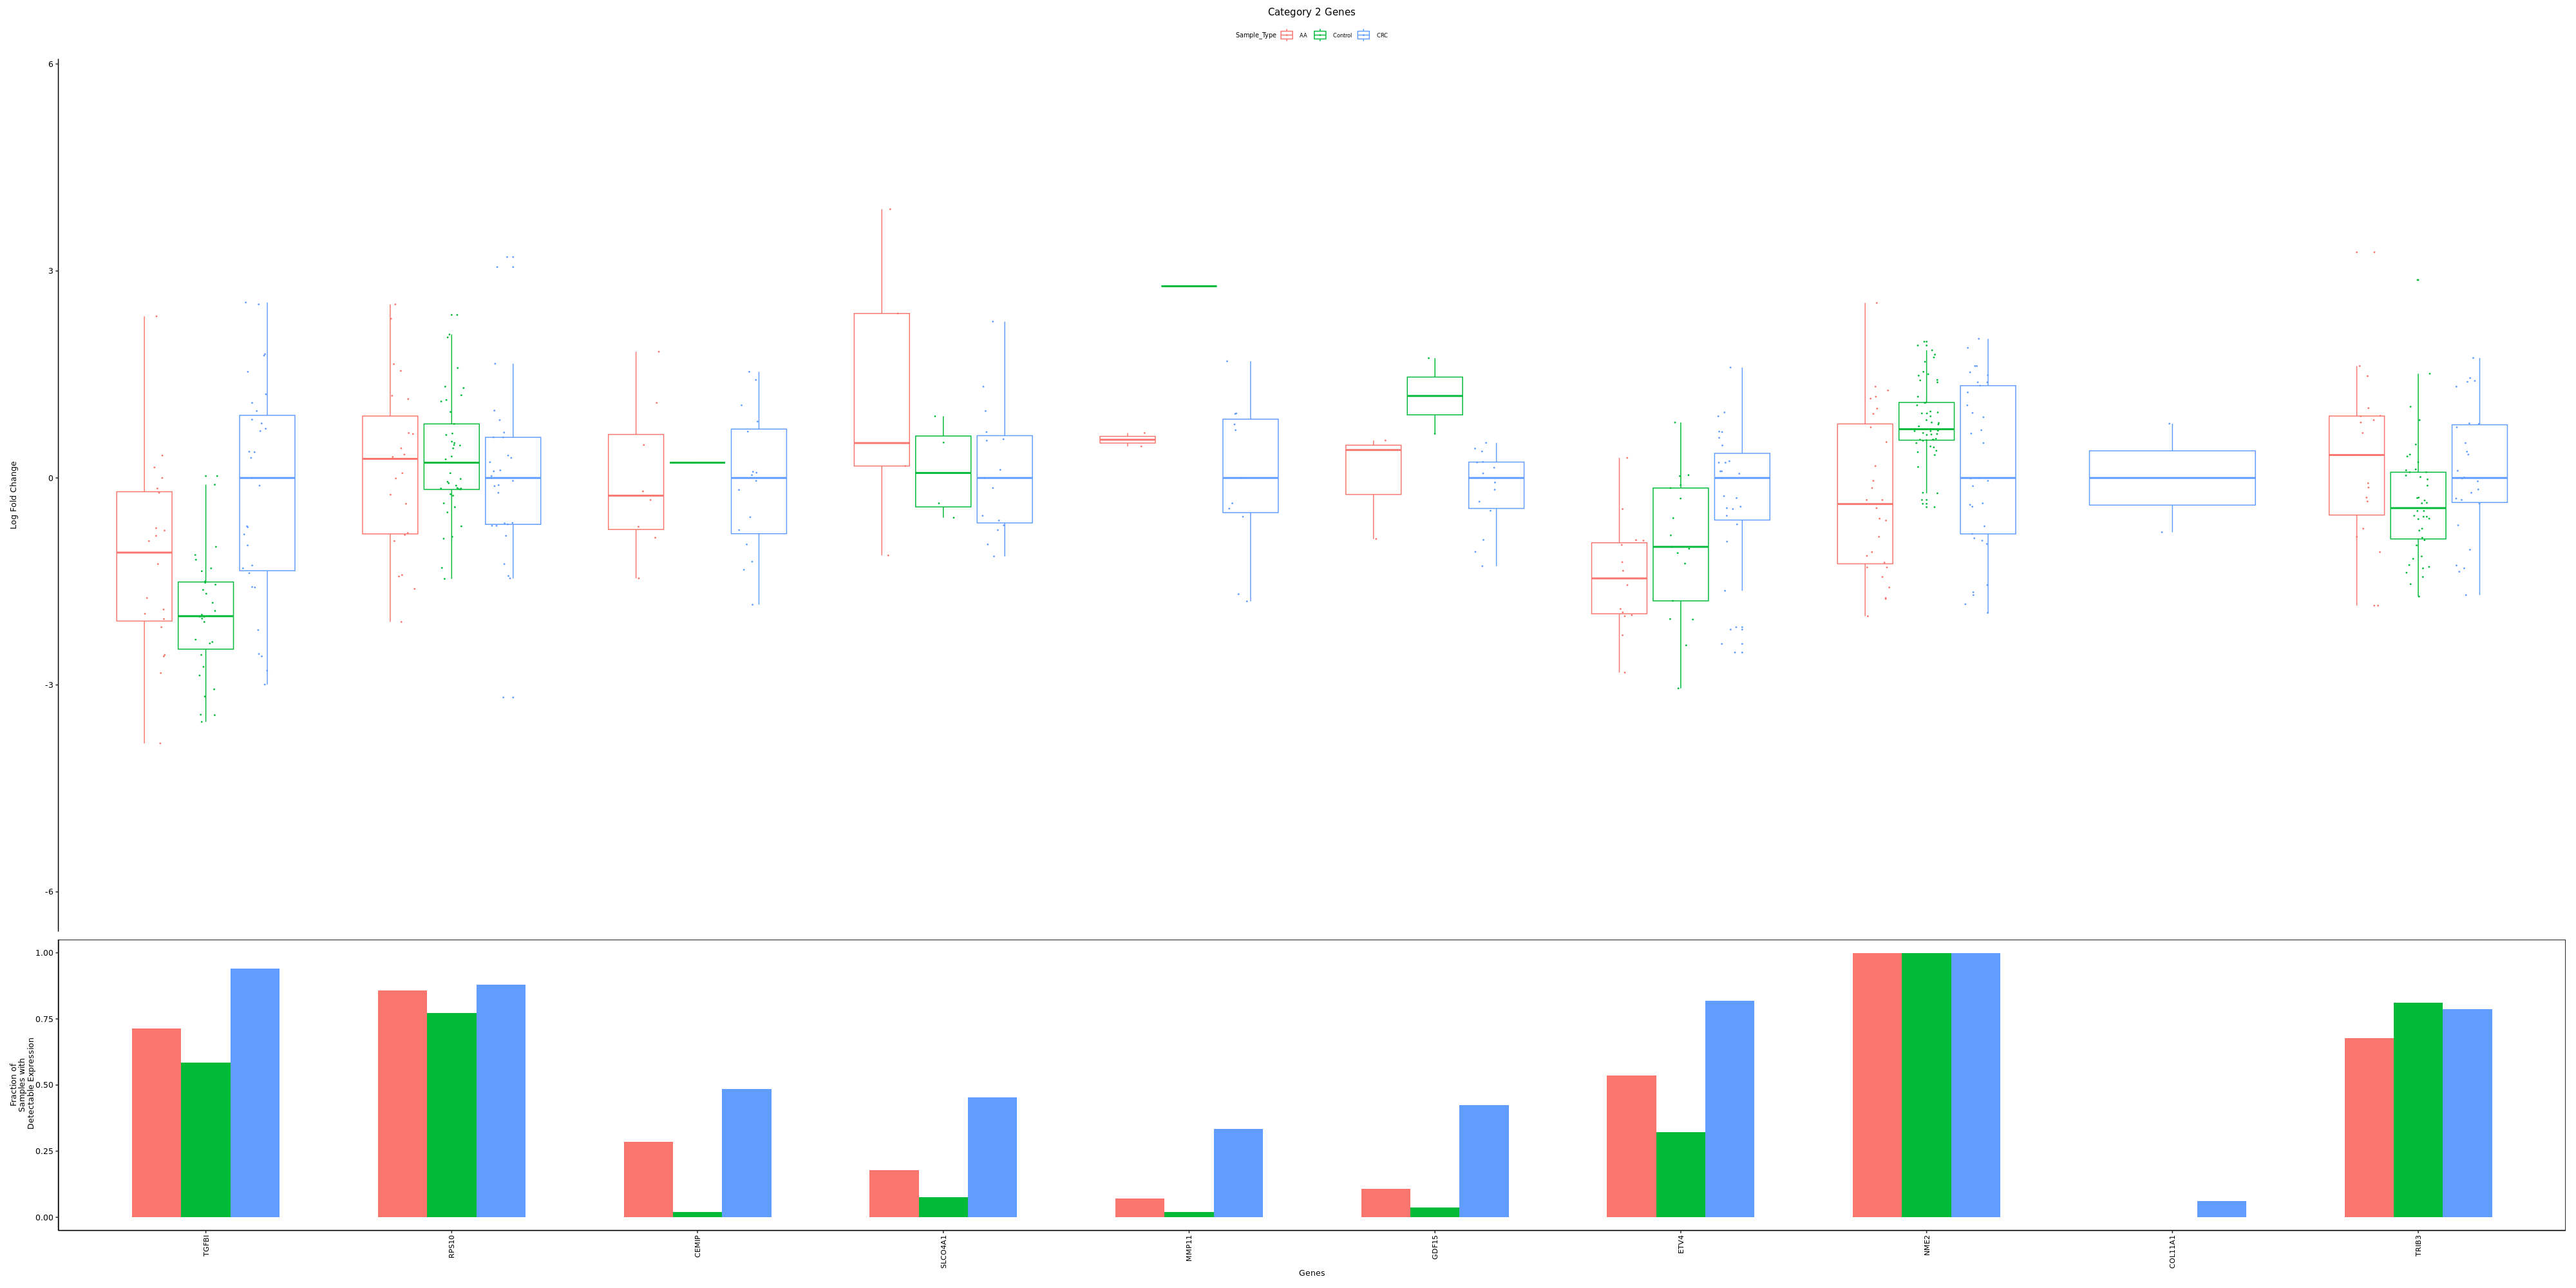

In [11]:
####Plotting genes normalized fold expression (Will be Figure 2A in manuscript) 
#######Plotting Figure 2B 

####getting the high CRC gene list
geneNames=c(top_high_CRC_list)


###Ct data manuscript plots normalized not raw Ct values but I include the possibility of plotting raw Ct
###values just in case we want to do it in the future. 
#expressionSubset=rawCT_long %>% filter(Genes %in% geneNames[1:length(geneNames)]) %>% 
#filter(Sample_Type %in% c("Col_Neg", "CON", "AA", "CRC") )

####normalized data
expressionSubset=Log_Fold_Expression_long_Undetectable_set_40 %>% filter(Genes %in% geneNames[1:length(geneNames)]) %>% 
filter(Sample_Type %in% c("Col_Neg", "CON", "AA", "CRC") )


##Setting which sapmles to use as the control merging colonoscopy negative samples with the control
indexes=which(expressionSubset$Sample_Type %in% c("Col_Neg", "CON"))
expressionSubset$Sample_Type[indexes]="Control"


## Plotting the data function will return a graphics object this is the function call for 
## plotting the data as an individual plot
#highCRCPlot=plotViolinPlots_normalized(expressionSubset, mainTitle="Category 2 Genes", ylab="Log_Fold_Expression", dataColumn = 3, 
 #               ylabScatterPlot=c("Log Fold Change", 
  #                           ylabBarPlot=c("Fraction of\nSamples With\nDetectable Expression")))


#Plotting the data function will return a graphics object this is the function call for 
## plotting the data where this plot will be combined with another plot to make Figure 2
highCRCPlot=plotViolinPlots_normalized(expressionSubset, mainTitle="Category 2 Genes", ylab="", dataColumn = 3, 
               ylabScatterPlot=c("Log Fold Change", 
                             ylabBarPlot=c("Fraction of\nSamples With\nDetectable Expression")))


#displaying the plot
highCRCPlot


##Saving plots as pngs 
#ggsave(filename="Graphs/top_ten_high_crc_normalized.png", dpi=300, width = 30,   height = 15, bg = "white")#ggsave(filename="Graphs/second_10_genes_Paper.png", dpi=300, width = 30,   height = 15, bg = "white")

#ggsave(filename="Graphs/Fig3.pdf", dpi=300, width = 6.6,   height = 6.8, bg = "white")


`summarise()` has grouped output by 'Genes'. You can override using the `.groups` argument.


# A tibble: 30 × 3
# Groups:   Genes [10]
   Genes Sample_Type Fraction_Samples_Detected
   <fct> <chr>                           <dbl>
 1 SIM2  AA                             0.25  
 2 SIM2  CRC                            0.576 
 3 SIM2  Control                        0.208 
 4 MMP3  AA                             0     
 5 MMP3  CRC                            0.424 
 6 MMP3  Control                        0.0189
 7 MMP1  AA                             0.75  
 8 MMP1  CRC                            0.909 
 9 MMP1  Control                        0.717 
10 CXCL8 AA                             1     
# ℹ 20 more rows


Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


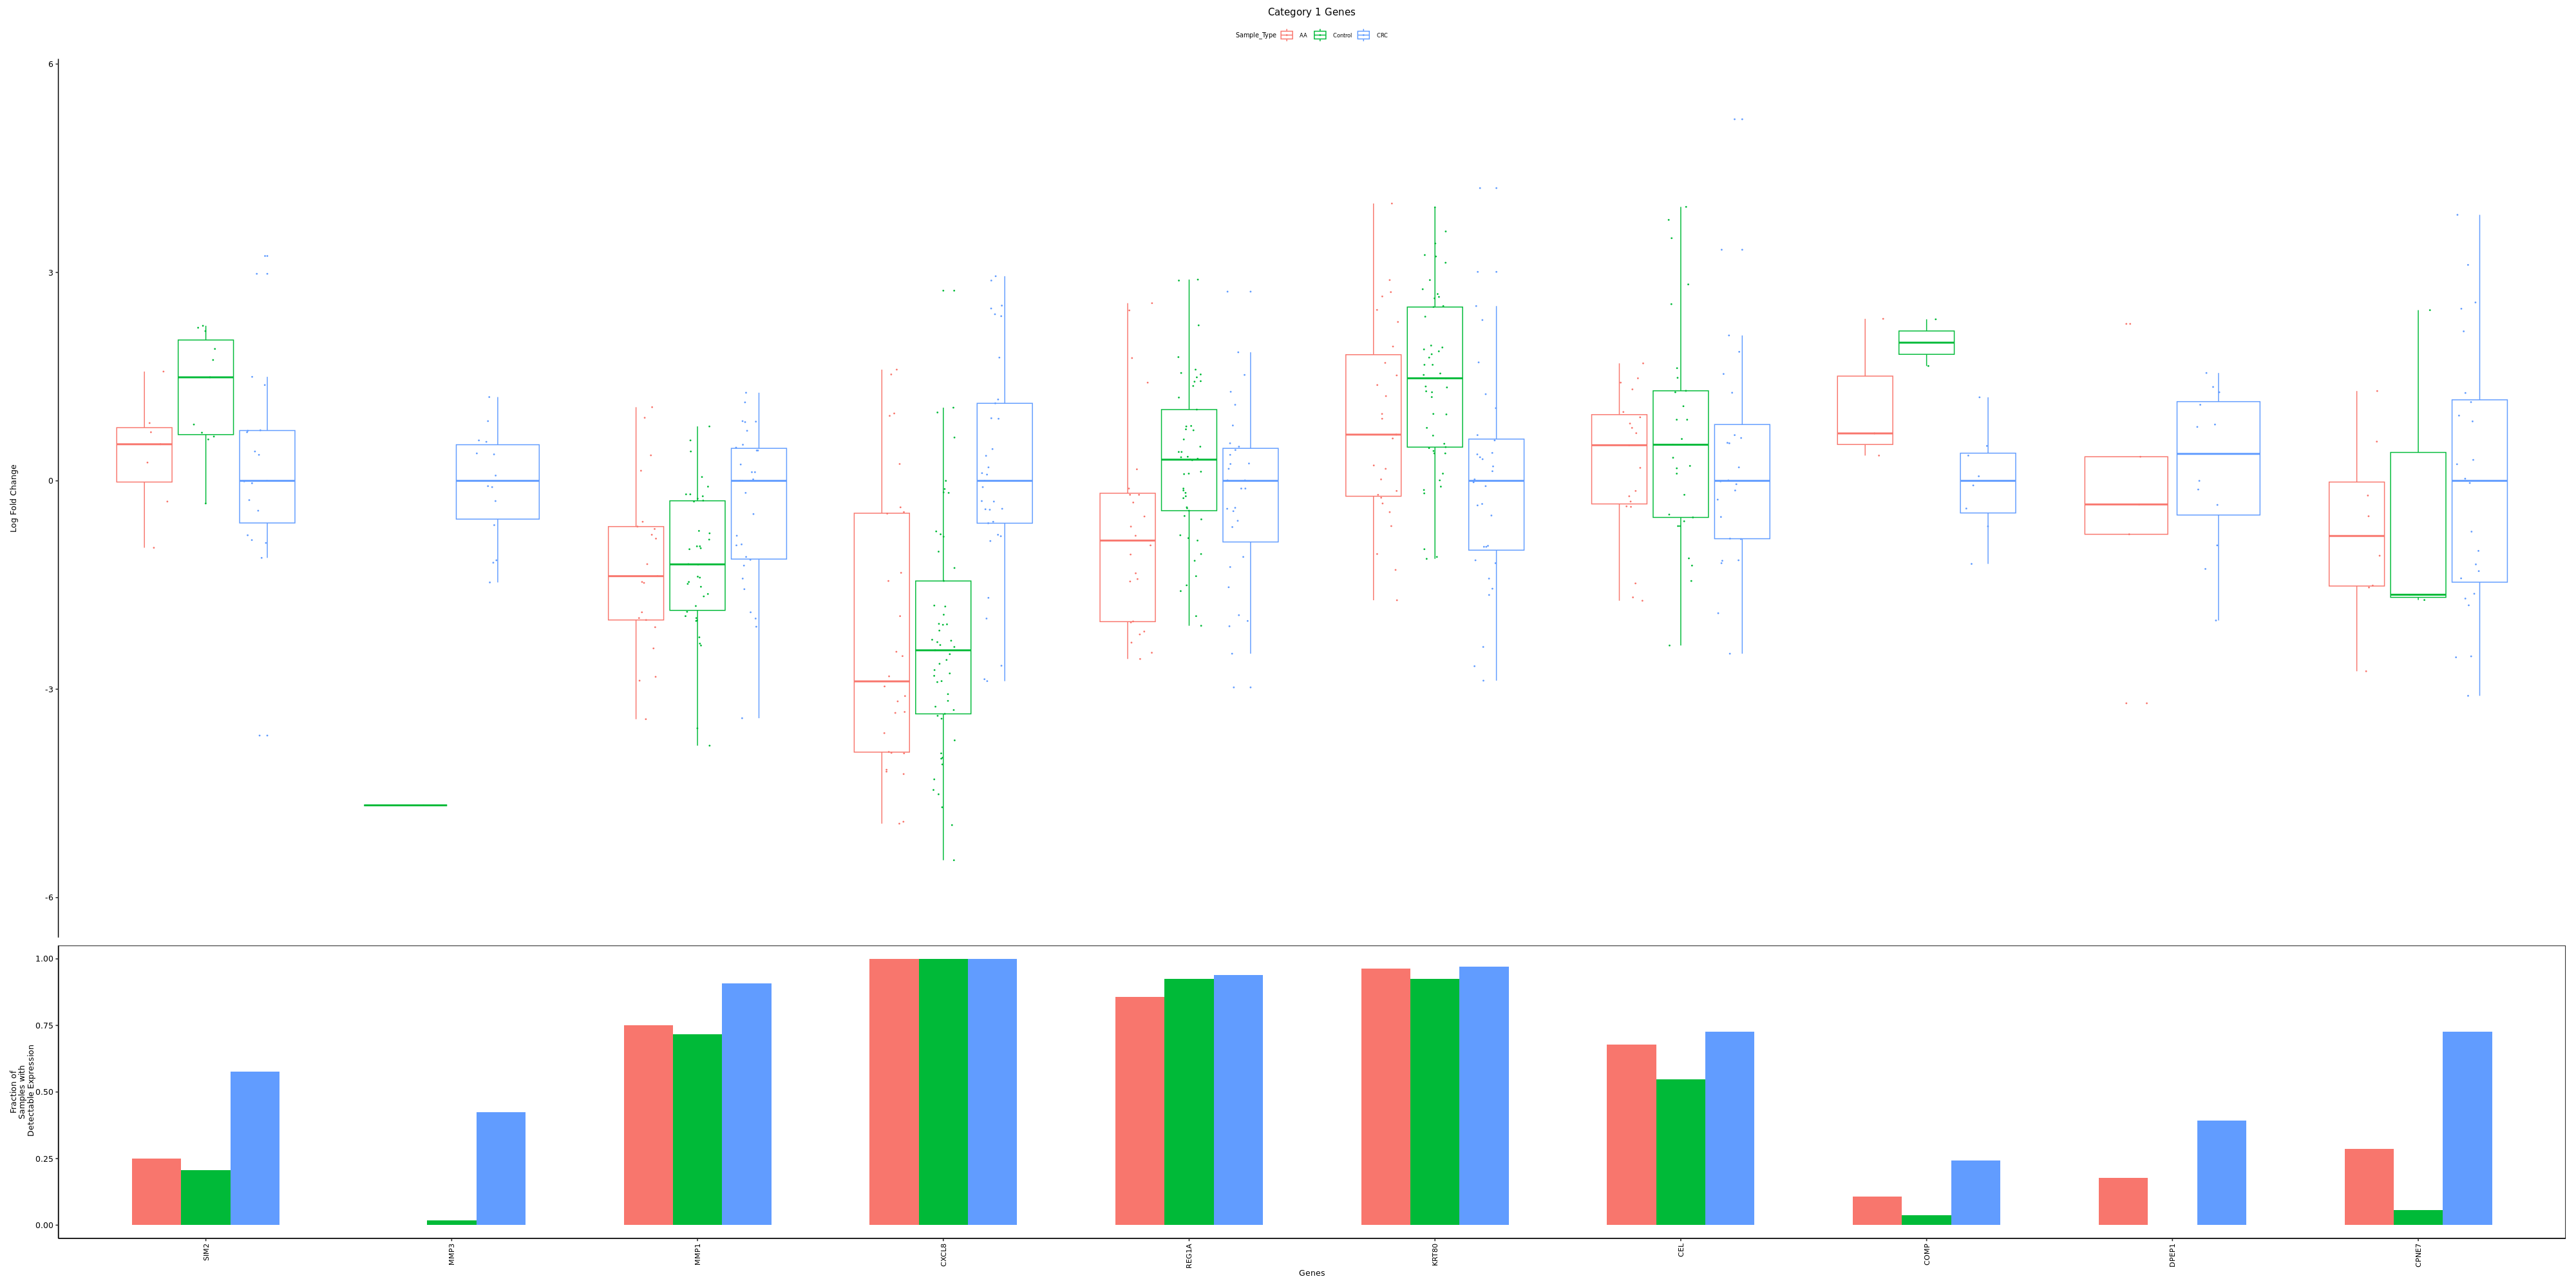

In [12]:
####Plotting genes normalized fold expression (Will be Figure 2B in manuscript) 


####Figure 2A genes 

#Getting the low background gene list
geneNames=c(top_low_background_list)


###Ct data manuscript plots normalized not raw Ct values but I include the possibility of plotting raw Ct
###values just in case we want to do it in the future. 
#expressionSubset=rawCT_long %>% filter(Genes %in% geneNames[1:length(geneNames)]) %>% 
#filter(Sample_Type %in% c("Col_Neg", "CON", "AA", "CRC") )

####normalized data
expressionSubset=Log_Fold_Expression_long_Undetectable_set_40 %>% filter(Genes %in% geneNames[1:length(geneNames)]) %>% 
filter(Sample_Type %in% c("Col_Neg", "CON", "AA", "CRC") )


##Setting which sapmles to use as the control merging colonoscopy negative samples with the control
indexes=which(expressionSubset$Sample_Type %in% c("Col_Neg", "CON"))
expressionSubset$Sample_Type[indexes]="Control"


##plotting the data function will return a graphics object
lowBackgroundPlot=plotViolinPlots_normalized(expressionSubset, mainTitle="Category 1 Genes", ylab="Log_Fold_Expression", dataColumn = 3, 
                ylabScatterPlot=c("Log Fold Change", 
                             ylabBarPlot=c("Fraction of\nSamples With\nDetectable Expression")), 
                                               topLeftLabel="")



#displaying the plot
lowBackgroundPlot


##Saving plots as pngs 
#ggsave(filename="Graphs/second_10_genes_Paper.png", dpi=300, width = 30,   height = 15, bg = "white")

ggsave(filename="Graphs/Fig2.pdf", dpi=300, width = 6.6,   height = 6.8, bg = "white")


Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


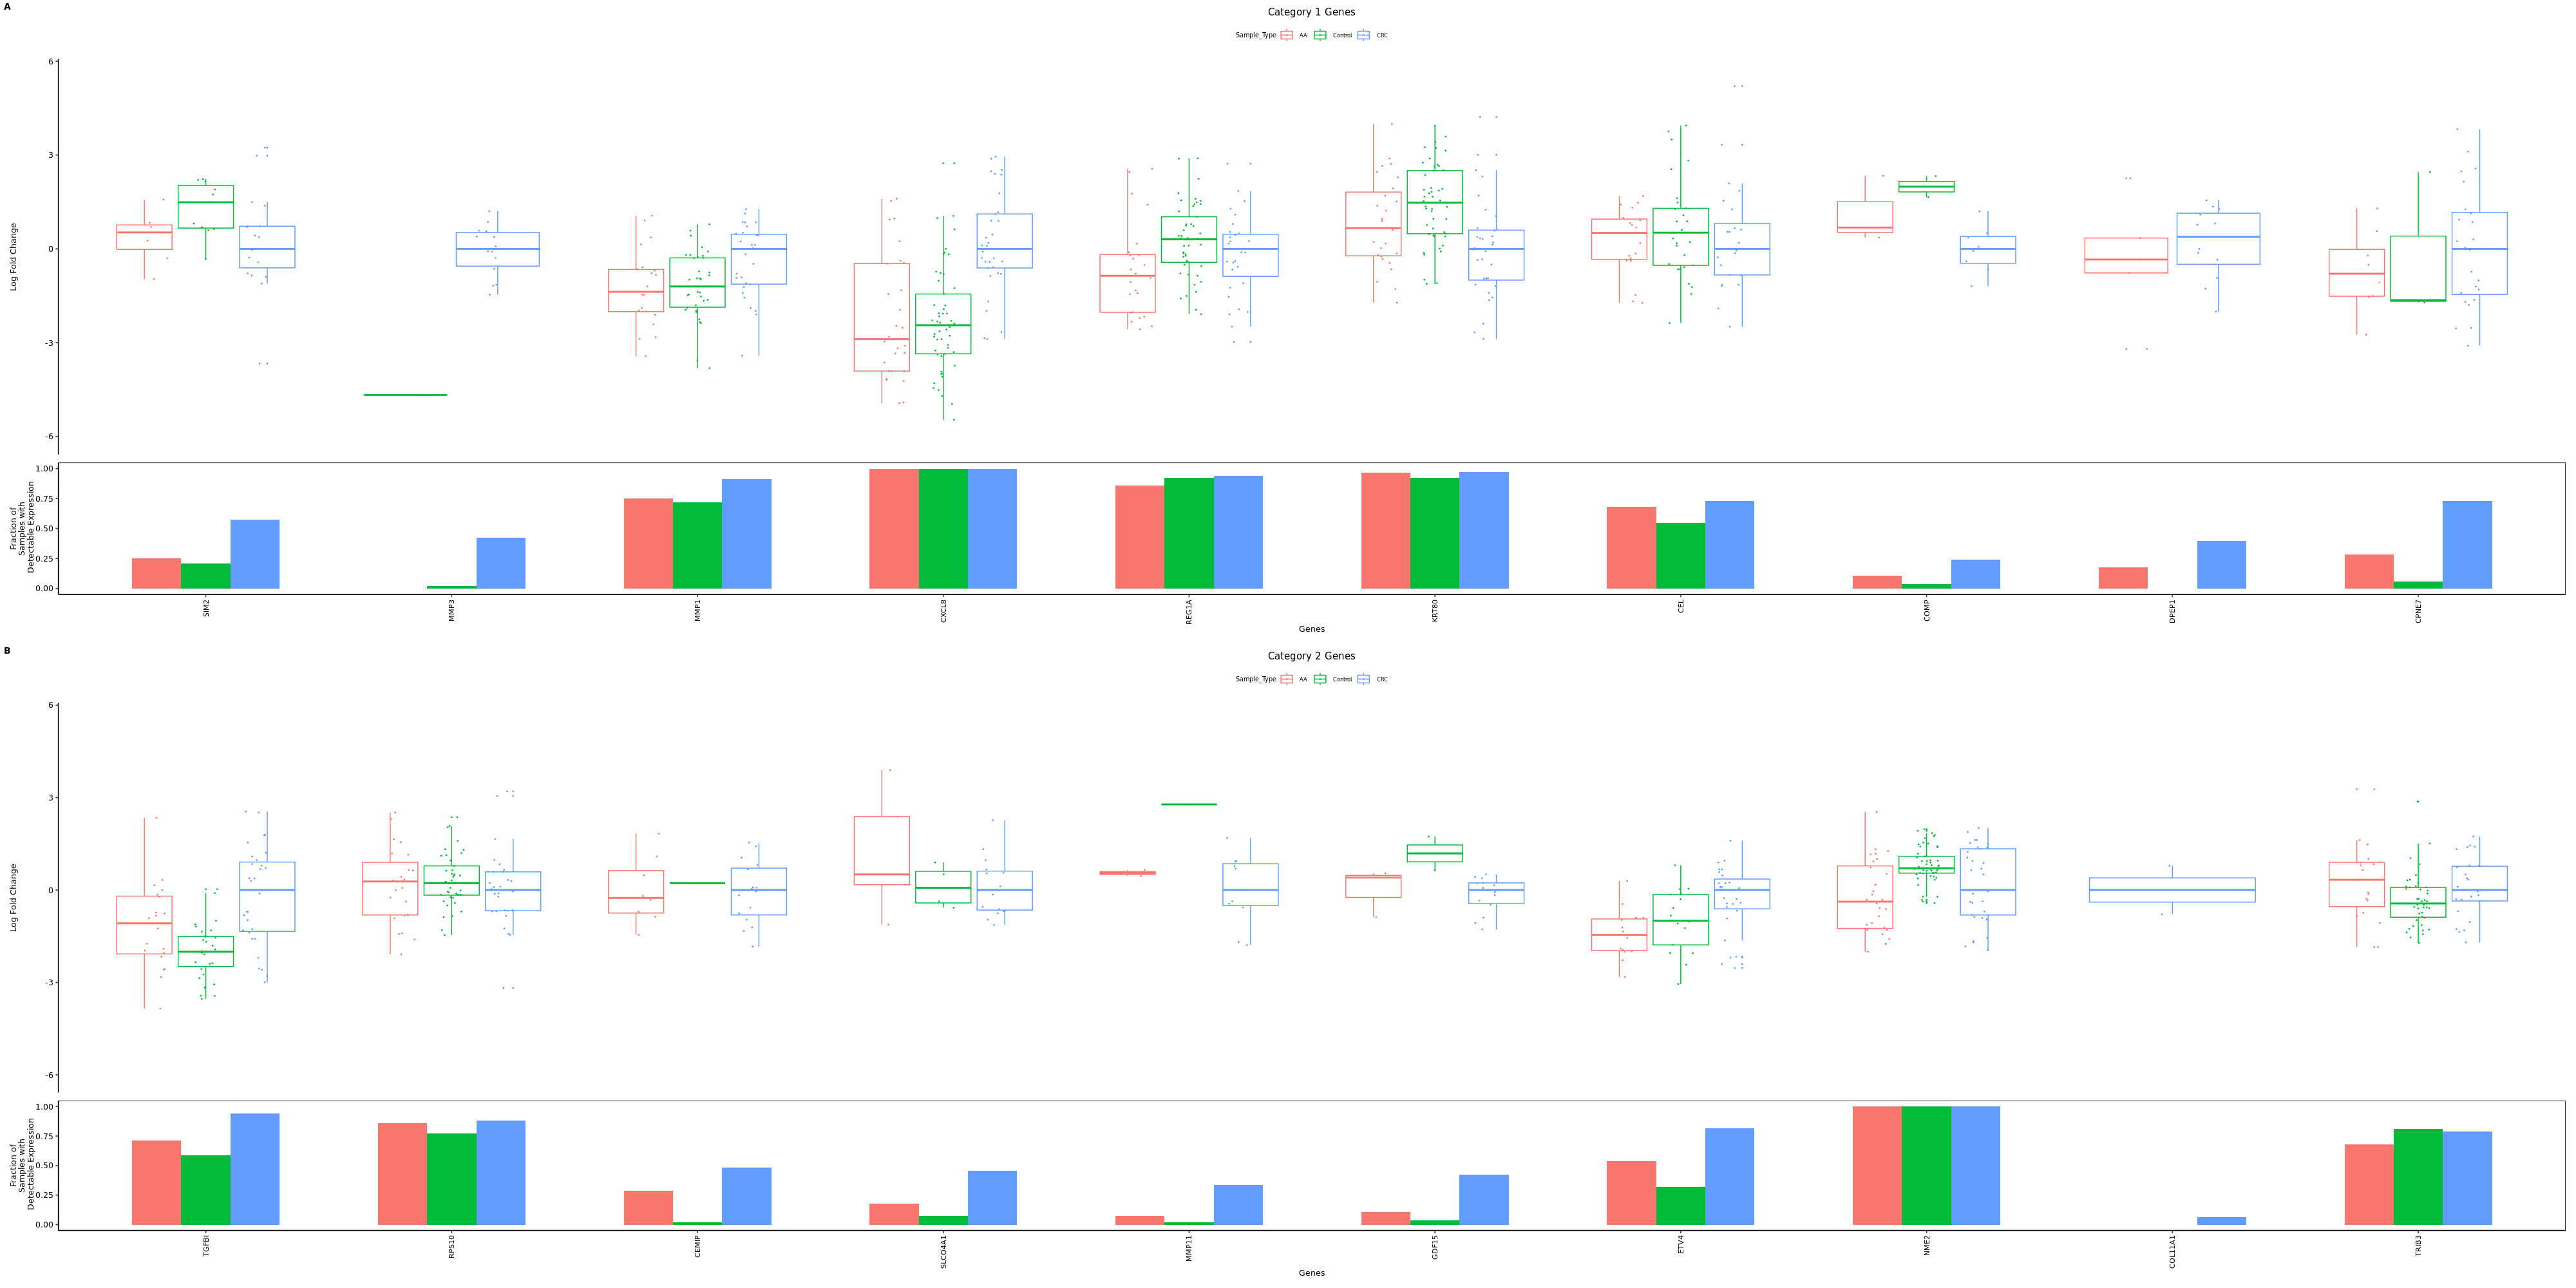

In [13]:
###Combining plot 2A and 2B into a single pdf file this is required for journal submission. 

##Adding panel letter 

#lowBackgroundPlot=lowBackgroundPlot+geom_text("text", x=0, y=2, size=10, label= "A") 


#lowBackgroundPlot=lowBackgroundPlot+annotate("text", x=1, y=1, size=10, label="Testing") 

#print(lowBackgroundPlot+annotate("text", x=-Inf, y=-Inf, size=20, fontface = "bold", label="A") )


###Combining plots 
#combinedGenePlot=lowBackgroundPlot|highCRCPlot

#print(combinedGenePlot)



combinedGenePlot=ggarrange(lowBackgroundPlot, highCRCPlot, labels=c("A", "B"), nrow=2, ncol=1, 
          font.label = list(size = 10))

print(combinedGenePlot)

ggsave(filename="Graphs/Fig2.pdf", dpi=300, width = 9.6,   height = 8.85, bg = "white")


`summarise()` has grouped output by 'Genes'. You can override using the `.groups` argument.


[1] "Correlation and statistical signficant of Control stool expression compared to tissue expression"



	Pearson's product-moment correlation

data:  pairedStoolTissue$Mean and pairedStoolTissue$N_mean
t = -3.0432, df = 19, p-value = 0.006689
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.8051634 -0.1869615
sample estimates:
       cor 
-0.5724468 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


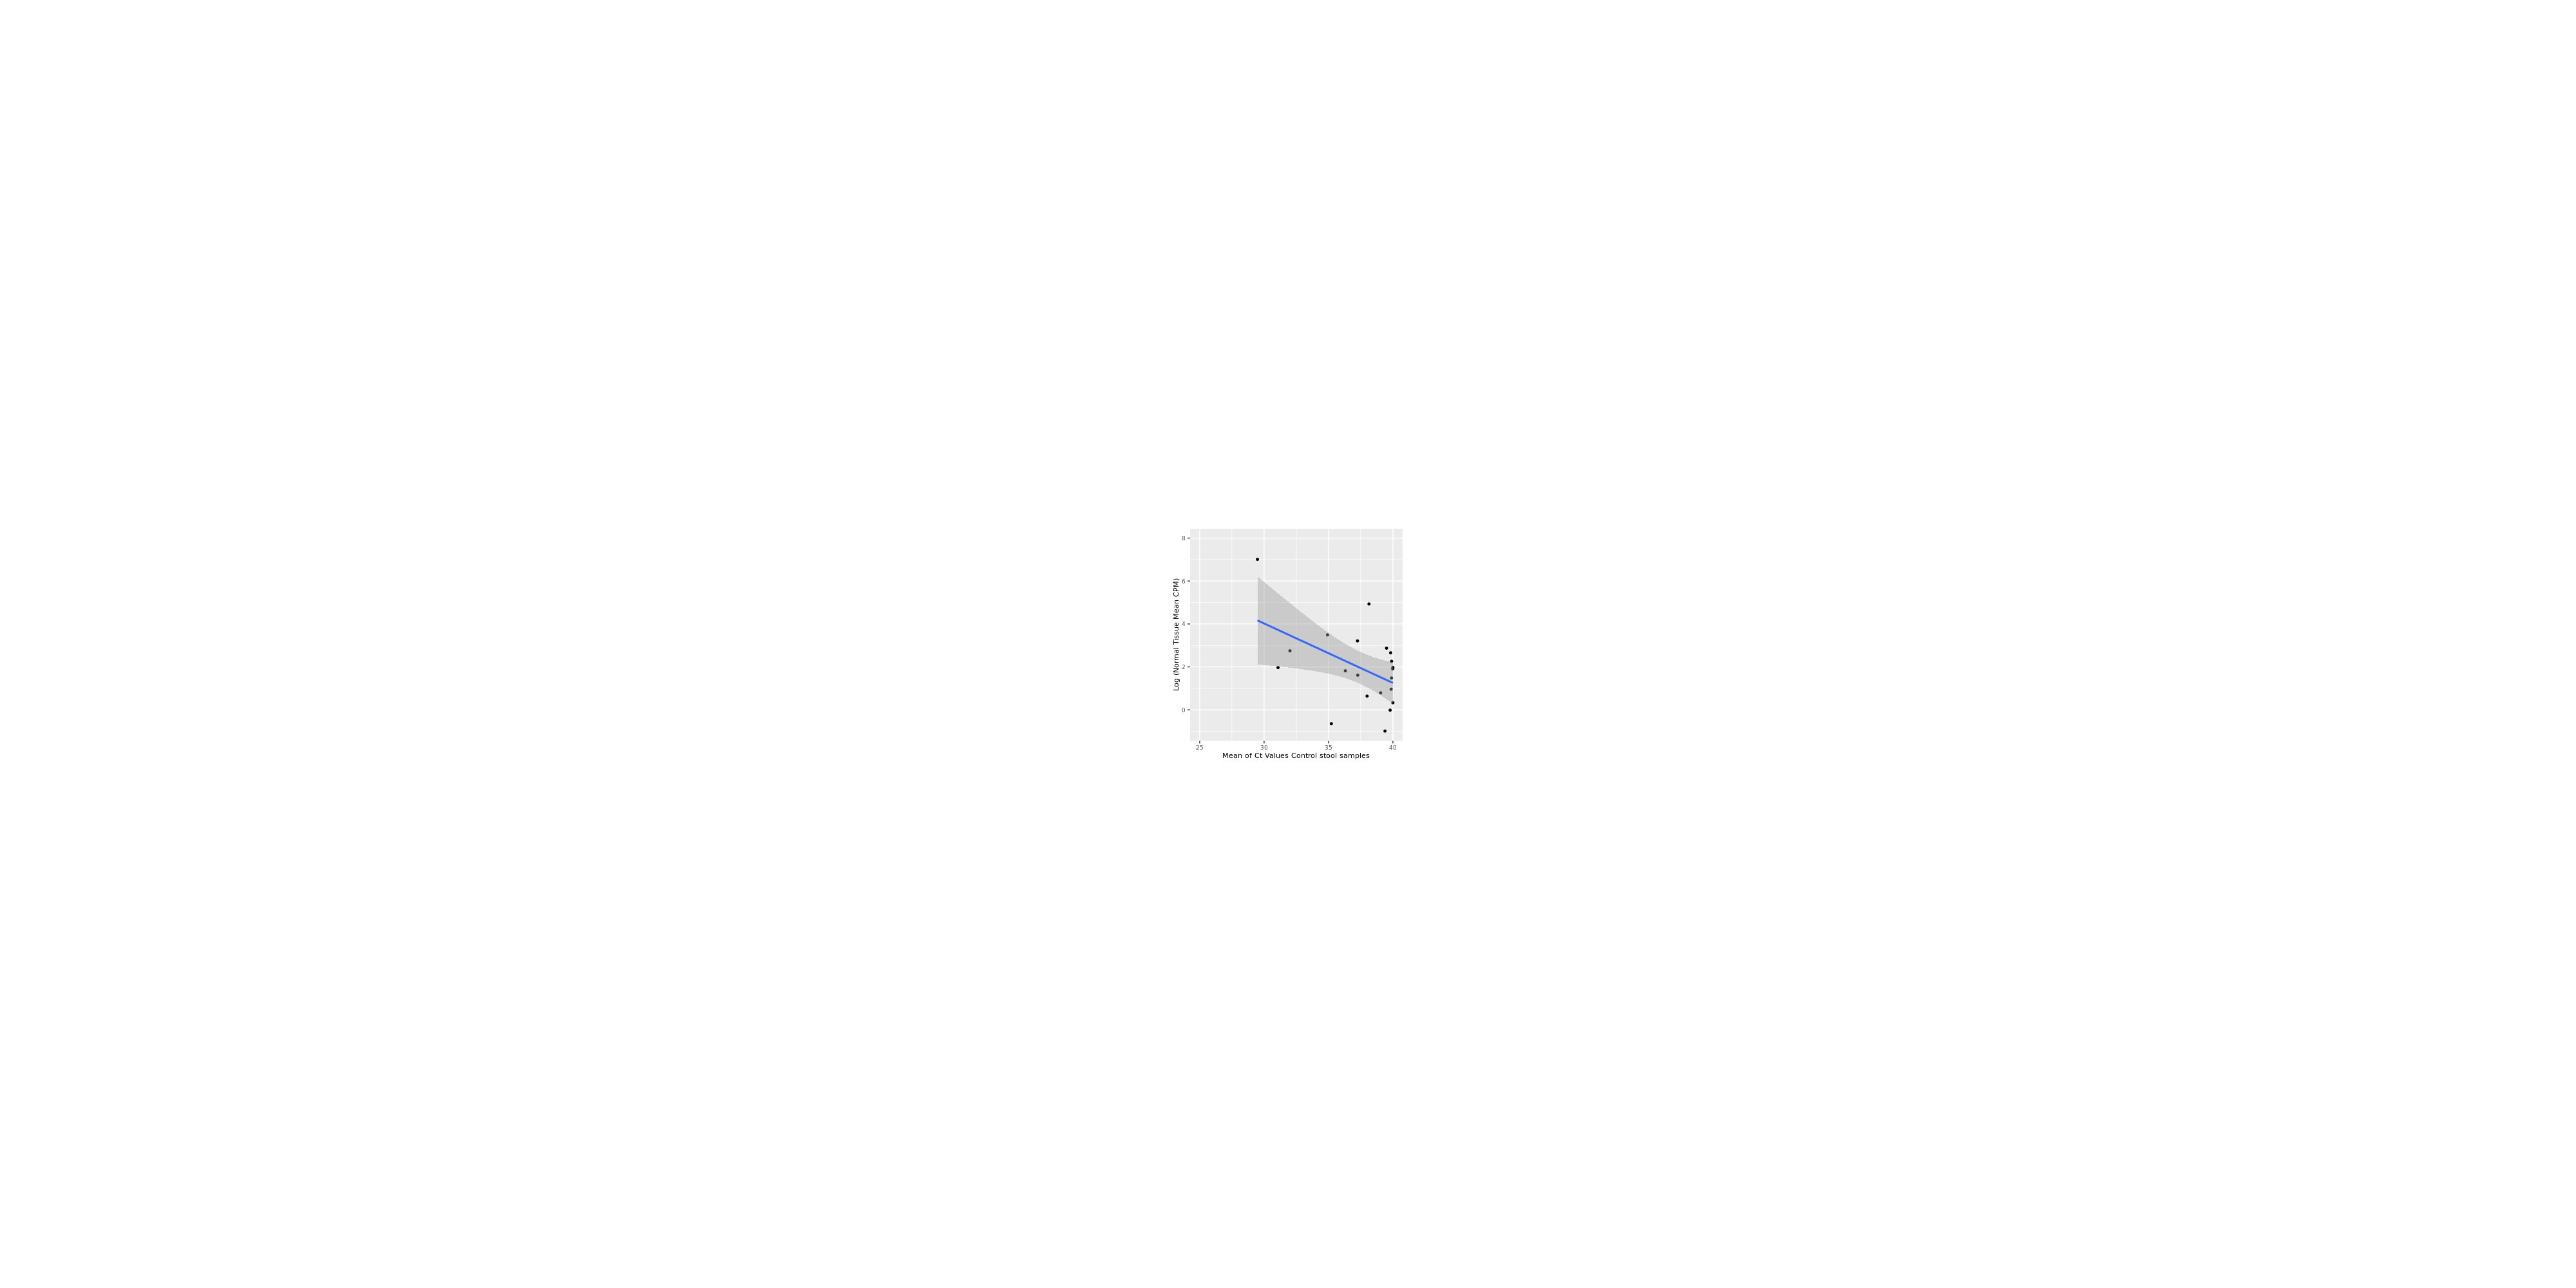

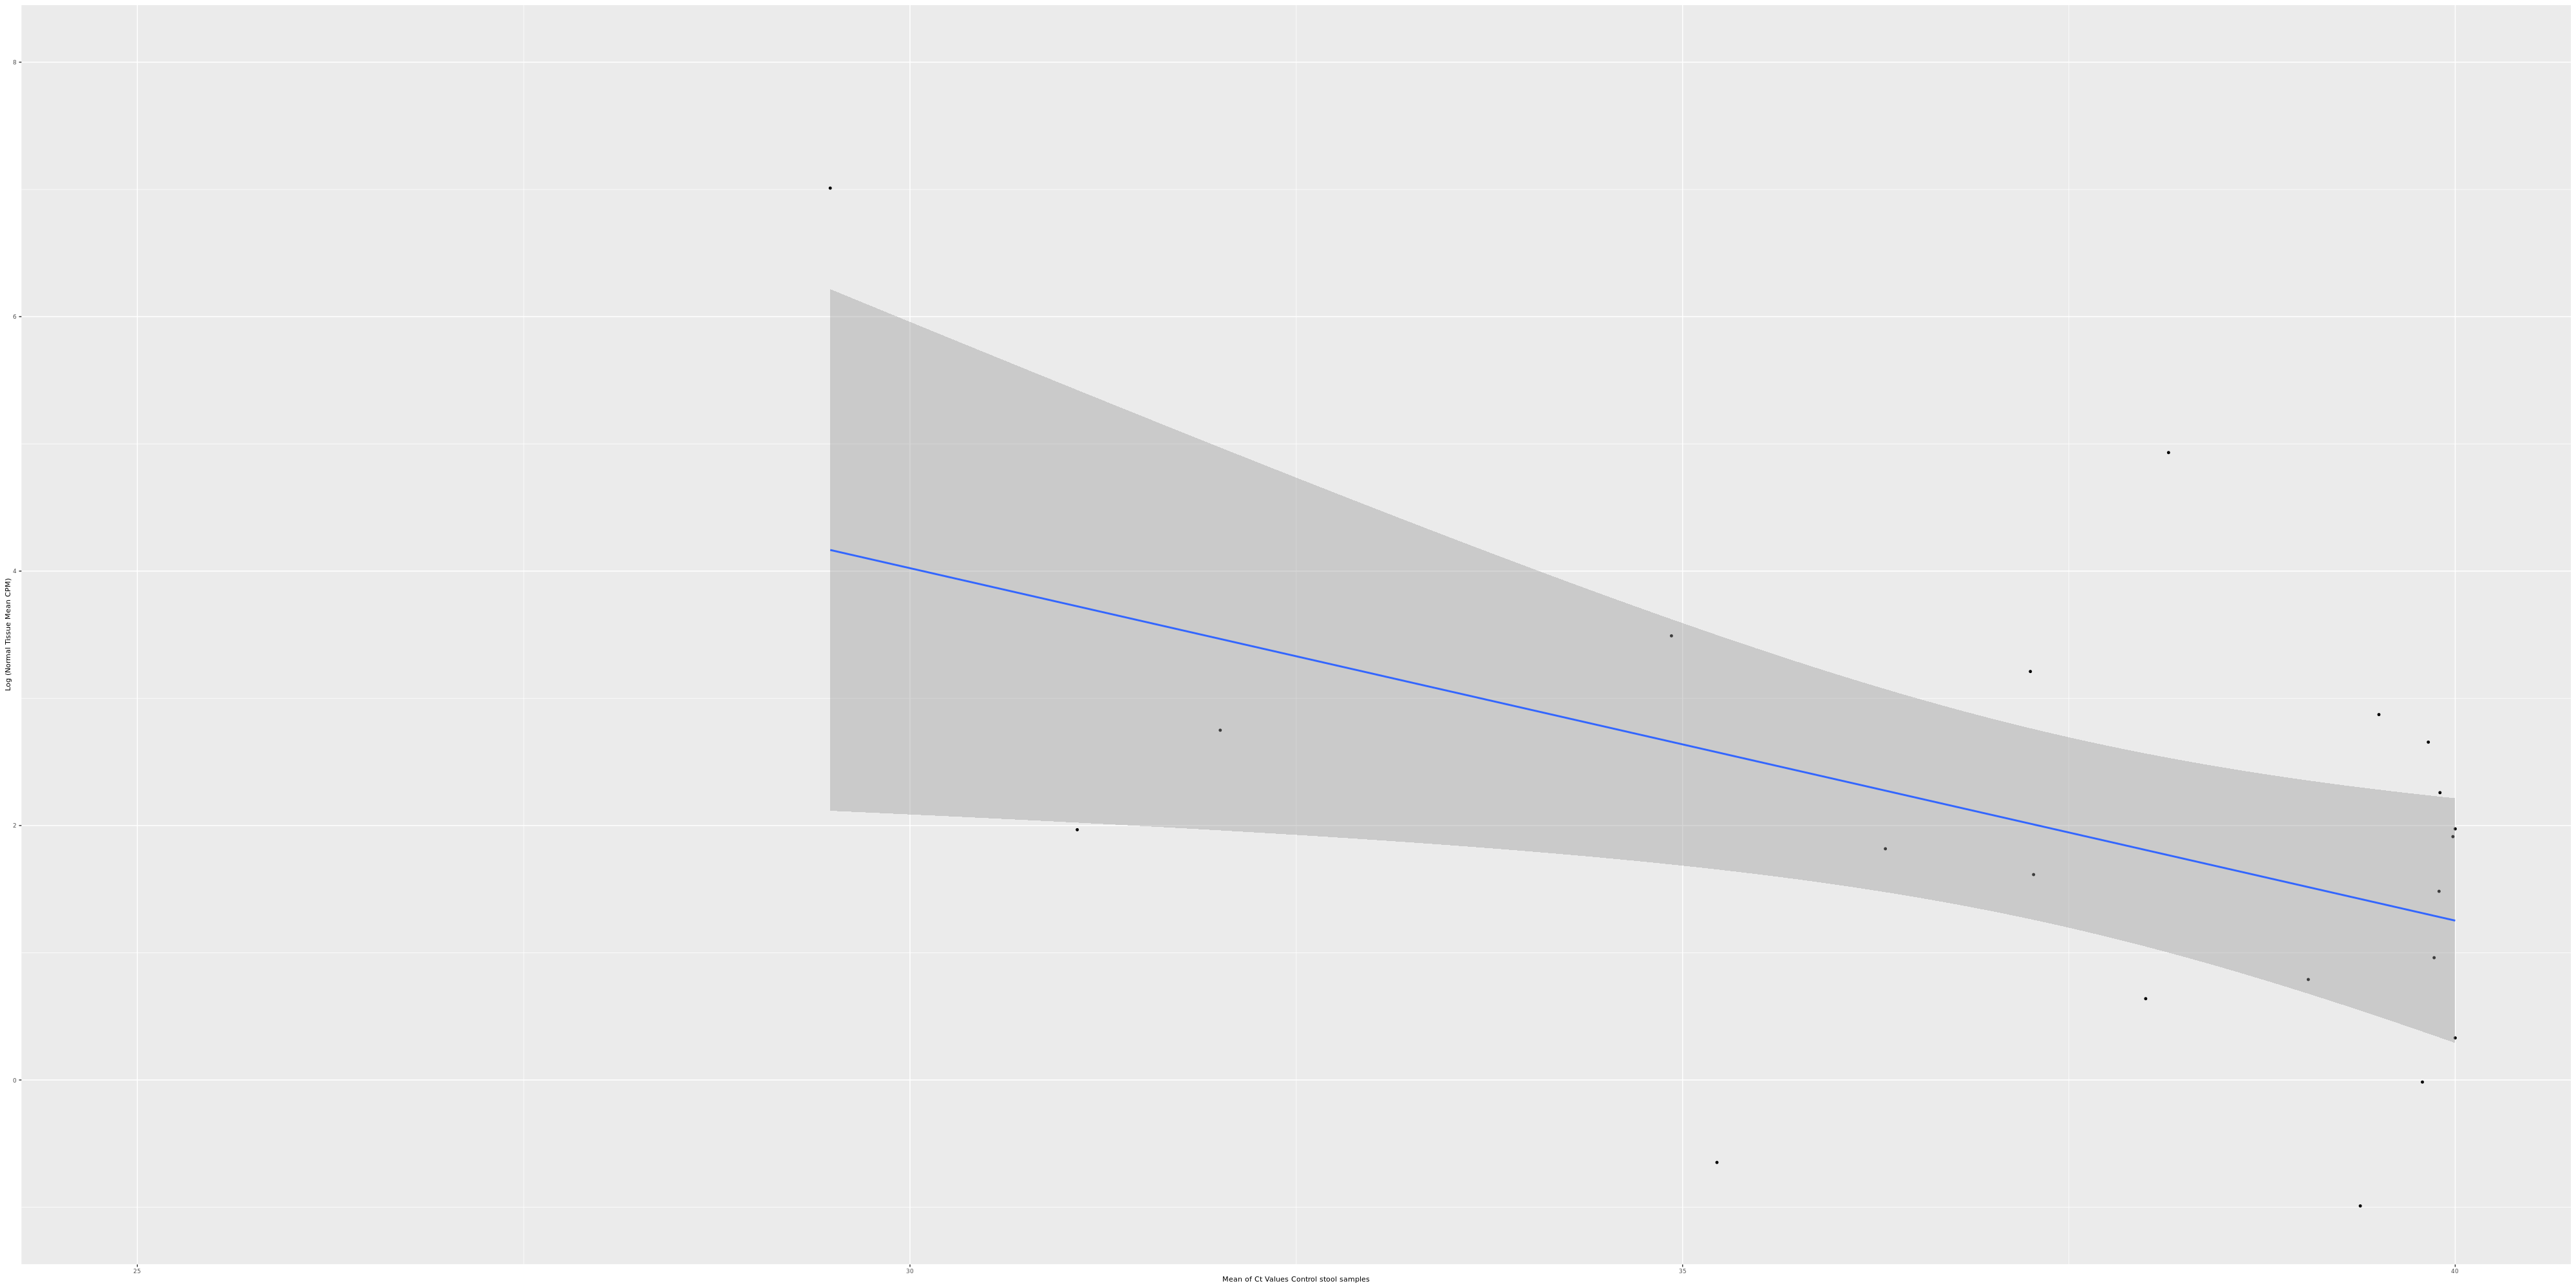

In [15]:
#########Figure 1 A

#calculating the mean expression level and correlating the tissue expresion level with measured stool

##Setting the samples to use as the control 
temp=which(rawCT_long$Sample_Type %in% c("Col_Neg", "CON"))
rawCT_long$Sample_Type[temp]="Control"



#Using normalized
#temp=which(foldExpression_long_Undetectable_set_0$Sample_Type %in% c("Col_Neg", "CON"))
#foldExpression_long_Undetectable_set_0$Sample_Type[temp]="Control"



##Using raw CT comparing tissue and stool expression for control samples (Figure 1A)
SampleTypeToUse="Control"

#Uncomment to compare CRC tissue with CRC stool i.e. (Figure 1B)
#SampleTypeToUse="CRC"

###Calculating the mean Ct per gene for each sample category i.e. mean Ct for CRC, mean Ct for Control
Group_means=rawCT_long %>% group_by(Genes,Sample_Type
                                               ) %>% summarize(Mean=mean(Ct, na.rm=TRUE))


##Calculating the mean normalized expression per gene for each sample category. The normalize value
##is NOT the right thing to use in this case since normalizing is relatively to a control gene and reference
##Set of samples and for this analysis we want something set as close as possible to the total amount of
###RNA in the stool I include the normalized correlation as a point of interest but it should NOT be used. 
#Group_means=Log_Fold_Expression_long_Undetectable_set_40 %>% group_by(Genes,Sample_Type 
 #                                           ) %>% summarize(Mean=mean(Log_Fold_Expression, na.rm=TRUE))


#extracting which sample types to compare
subset=Group_means %>% filter(Sample_Type==SampleTypeToUse)

#making the gene names more readable anything after the period
subset$Genes=gsub("\\..*","",subset$Genes)


#link mean stool expression with mean tissue expression
pairedStoolTissue=merge(subset, TCGA_Gtex_results, by.x=c("Genes"), by.y=c("Gene"))



 options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)

##generating the the scatter plot obect
plot_Normal=ggplot(pairedStoolTissue, aes(x=Mean, y=log(N_mean))) + geom_point(size=1)+geom_smooth(method = lm)+
theme(text = element_text(size=8))+labs(y="Log (Normal Tissue Mean CPM)", x="Mean of Ct Values Control stool samples")+xlim(25,40)+scale_y_continuous(limits = c(-1, 8))


###Calculating the correlation coefficient and statistical significance of the correlation 
print("Correlation and statistical signficant of Control stool expression compared to tissue expression")
cor.test(pairedStoolTissue$Mean, pairedStoolTissue$N_mean, method = "pearson")

gridExtra::grid.arrange(egg::set_panel_size(p=plot_Normal, width=unit(3.3, "in"), height=unit(3.3, "in")))


##plotting the scatter plot
plot_Normal

###Saving the plot as a png
#normal plot
#ggsave(filename="Graphs/corr_Normal_with_stool.png", dpi=300, width = 30,   height = 20, bg = "white")


`summarise()` has grouped output by 'Genes'. You can override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


[1] "Correlation and statistical signficant of CRC stool expression compared to tissue expression"



	Pearson's product-moment correlation

data:  pairedStoolTissue$Mean and pairedStoolTissue$T_mean
t = -2.4894, df = 19, p-value = 0.02223
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.76404329 -0.08173905
sample estimates:
       cor 
-0.4959267 


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


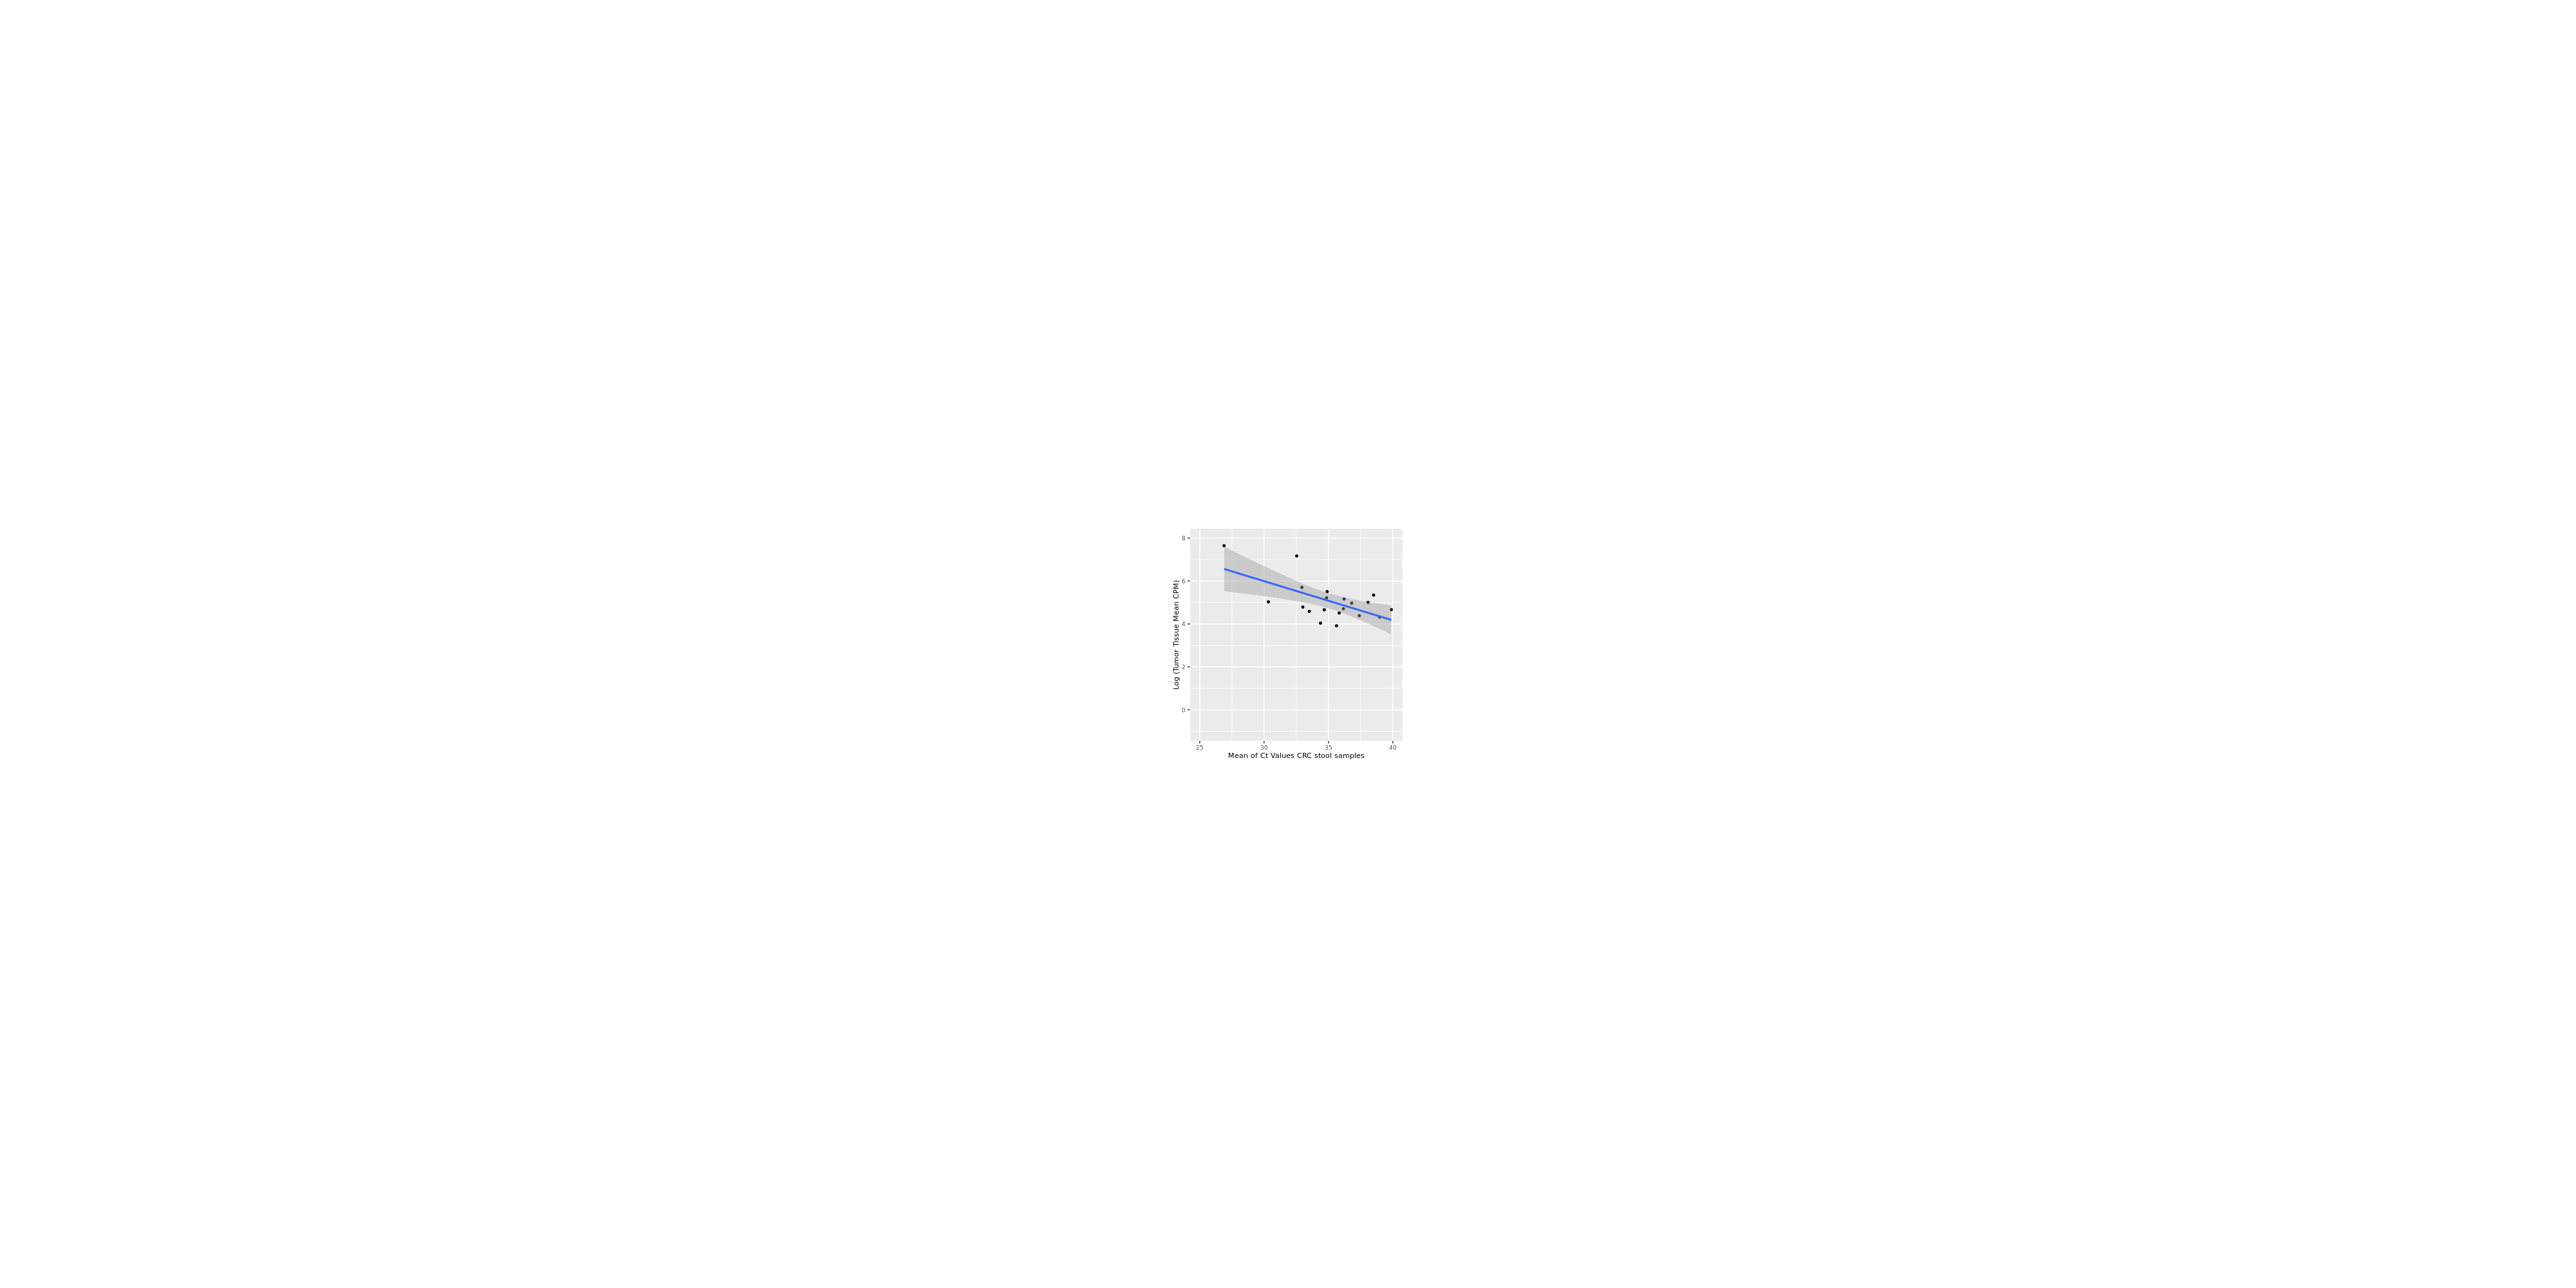

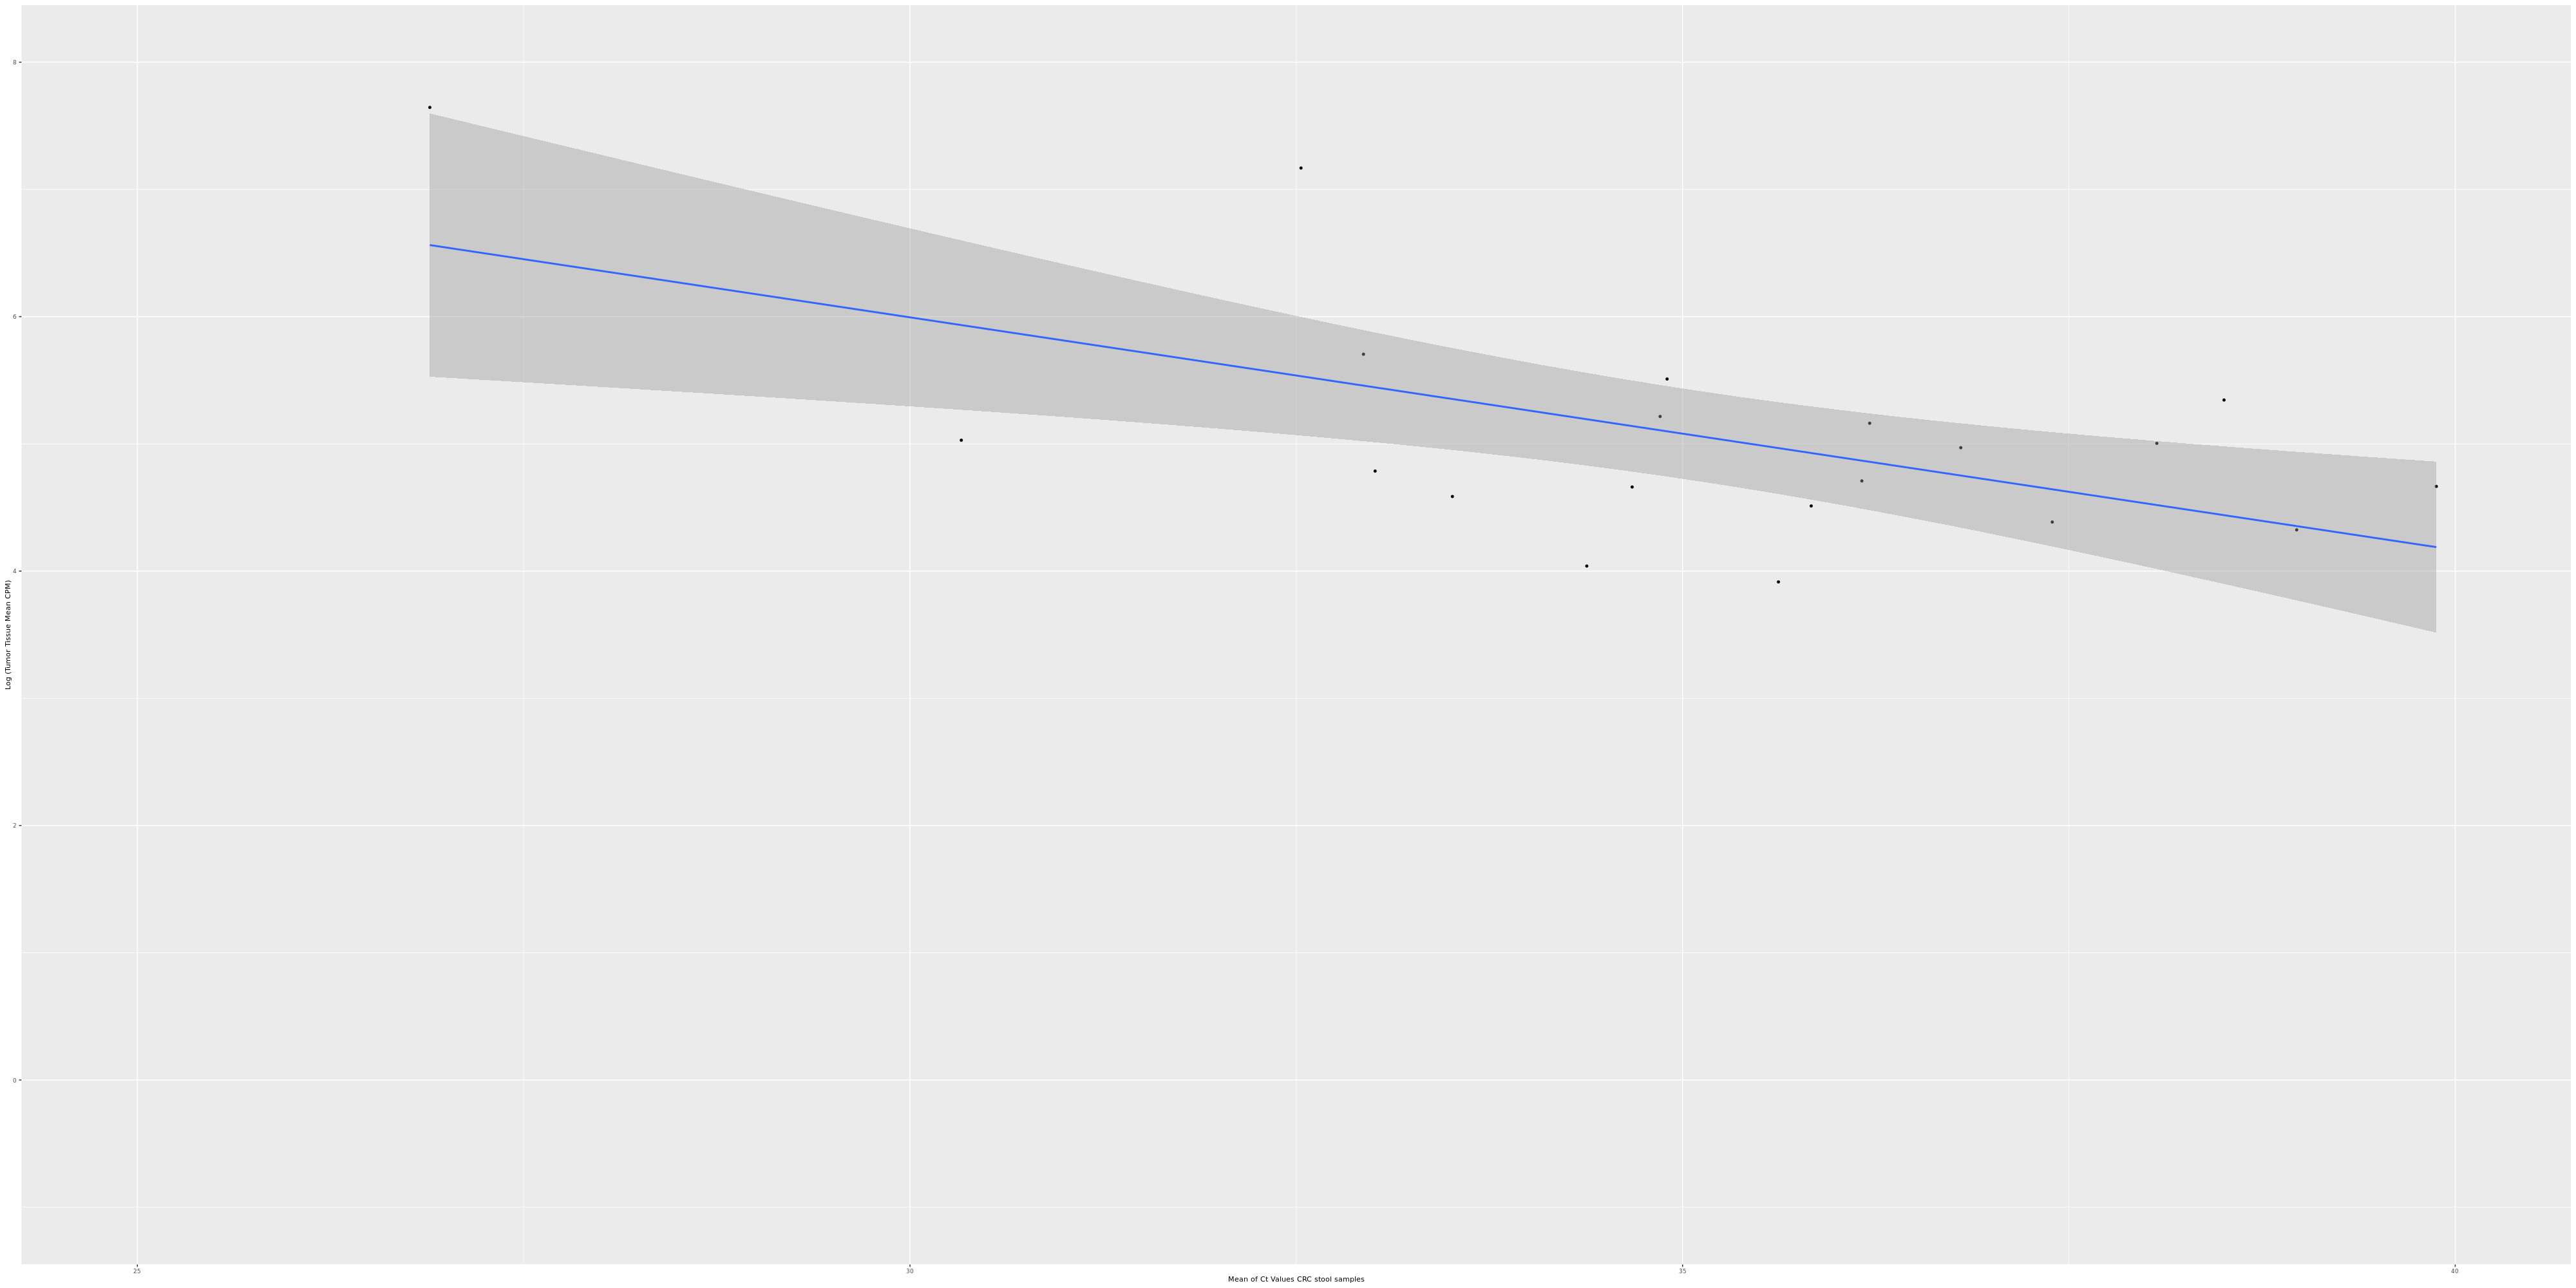

In [16]:
#########Figure 1 B

#calculating the mean expression level from CRC stool samples 
##and comparing with CRC tissue measured expression levels. 

##Setting the samples to use as the control 
temp=which(rawCT_long$Sample_Type %in% c("Col_Neg", "CON"))
rawCT_long$Sample_Type[temp]="Control"



#Compare CRC tissue with CRC stool i.e. (Figure 1B)
SampleTypeToUse="CRC"

###Calculating the mean Ct per gene for each sample category i.e. mean Ct for CRC, mean Ct for Control
Group_means=rawCT_long %>% group_by(Genes,Sample_Type
                                               ) %>% summarize(Mean=mean(Ct, na.rm=TRUE))


##Calculating the mean normalized expression per gene for each sample category. The normalize value
##is NOT the right thing to use in this case since normalizing is relative to a control gene and reference
##Set of samples and for this analysis we want something set as close as possible to the total amount of
###RNA in the stool I include the normalized correlation as a point of interest but it should NOT be used. 
#Group_means=Log_Fold_Expression_long_Undetectable_set_40 %>% group_by(Genes,Sample_Type 
 #                                           ) %>% summarize(Mean=mean(Log_Fold_Expression, na.rm=TRUE))


#extracting which sample types to compare
subset=Group_means %>% filter(Sample_Type==SampleTypeToUse)

#making the gene names more readable anything after the period
subset$Genes=gsub("\\..*","",subset$Genes)


#link mean stool expression with mean tissue expression
pairedStoolTissue=merge(subset, TCGA_Gtex_results, by.x=c("Genes"), by.y=c("Gene"))


###remove housekeeping genes this is not necassary for the paper but was of interest to see what impact
###this might have
#indexes=which(pairedStoolTissue$Genes %in% c("ACTB", "GAPDH"))
#pairedStoolTissue=pairedStoolTissue[-indexes, ]


##generating the the scatter plot object
plot_Tumor=ggplot(pairedStoolTissue, aes(x=Mean, y=log(T_mean))) + geom_point(size=1)+geom_smooth(method = lm)+
theme(text = element_text(size=8))+labs(y="Log (Tumor Tissue Mean CPM)", x="Mean of Ct Values CRC stool samples")+xlim(25,40)+scale_y_continuous(limits = c(-1, 8))

#plot_Tumor=plot_Tumor+coord_fixed(ratio = 1)
gridExtra::grid.arrange(egg::set_panel_size(p=plot_Tumor, width=unit(3.3, "in"), height=unit(3.3, "in")))


###Calcualting the correlatino coefficient and statistical significance of the correlation 
print("Correlation and statistical signficant of CRC stool expression compared to tissue expression")
cor.test(pairedStoolTissue$Mean, pairedStoolTissue$T_mean, method = "pearson")

##plotting the scatter plot
plot_Tumor

#crc plot
#ggsave(filename="Graphs/corr_CRC_with_stool.png", dpi=300, width = 30,   height = 20, bg = "white")


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


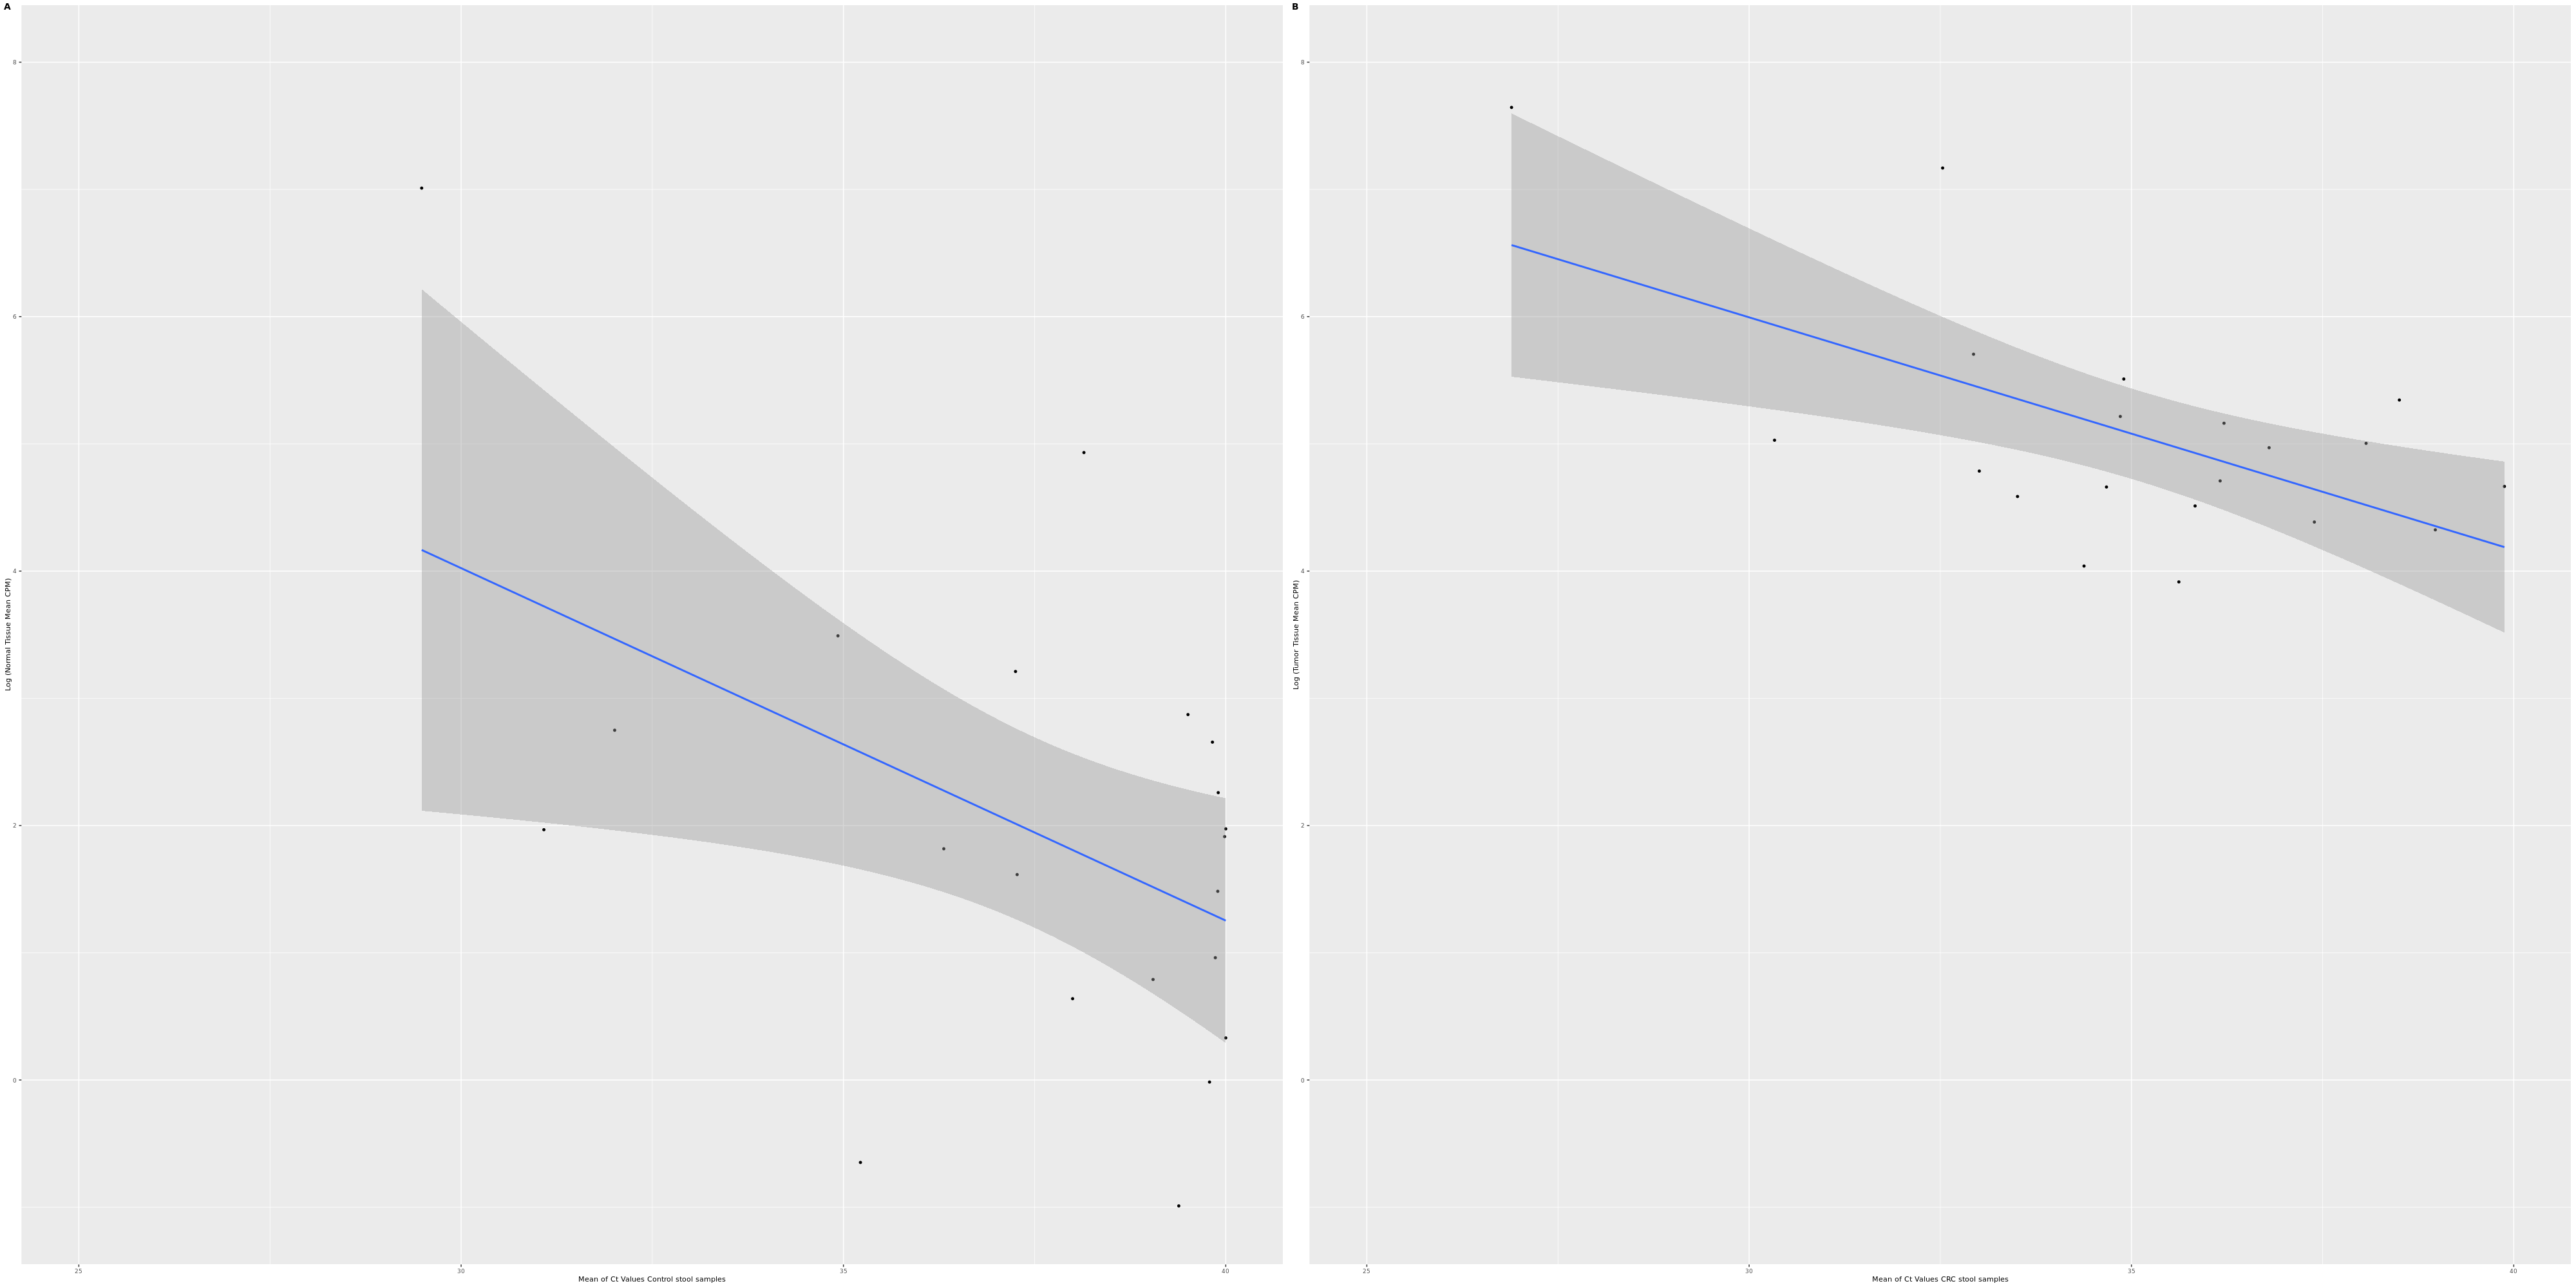

In [18]:


combined_Fig1=ggarrange(plot_Normal, plot_Tumor, labels=c("A", "B"), nrow=1, ncol=2, 
          font.label = list(size = 10))


print(combined_Fig1)

ggsave(filename="Graphs/Fig1.pdf", dpi=300, width = 6.6, height = 3.3, bg = "white")






In [19]:
##########Calculate performance metrics for each gene using normalized values and getting list of 
##########Genes statistically significantly different in CRC or AA compared to Controls this data
##### is part of the data displayed in Tables 3 and 4

controlGroup=c("Col_Neg", "CON")

######### Calculate metrics for CRC 

#Calculating AUC for each gene
aucResultsCRC=getAUC(foldExpression_wide, refColumns=controlGroup)


#get AUC data into a form that can be merged with AUC p-value calculation
aucResultsCRC=as.data.frame(t(aucResultsCRC))
aucResultsCRC$Genes=rownames(aucResultsCRC)

#calculating the pvalues and other metrics
aucPValueCRC=testDifferentialExpression(foldExpression_wide, diseaseGroup="CRC", controlGroup=controlGroup)

#adding AUC to pvalue and other metrics
aucResultsCRC=merge(aucResultsCRC, aucPValueCRC, by="Genes")


#setting CRC results columns names
colnames(aucResultsCRC)[5:14]=c("CRC_Mann_pvalue", "CRC_medianTumor", "medianNormal", 
                                            "CRC_meanTumor", "meanNormal", "CRC_%_Detectable",
                                            "Normal_%_Detectable", "CRC_Fisher_pvalue",  
                                           "CRC_Mann_FDR", "CRC_Fisher_FDR")

####### Calculate metrics for AA 

#calculating the pvalue of the AUC
aucPValueAA=testDifferentialExpression(foldExpression_wide, diseaseGroup="AA", controlGroup=controlGroup)


#setting AA results column names
colnames(aucPValueAA)[2:11]=c("AA_Mann_pvalue", "AA_medianTumor", "medianNormal", 
                                            "AA_meanTumor", "meanNormal", "AA_%_Detectable",
                                            "Normal_%_Detectable", "AA_Fisher_pvalue",  
                                           "AA_Mann_FDR", "AA_Fisher_FDR")


#removing duplicate columns these will be the normal metrics columns these columns were already calculated
#for the CRC versus normal comparision
aucPValueAA=aucPValueAA[, -c(4, 6, 8)]


####Merging CRC and AA results
aucResults=merge(aucResultsCRC, aucPValueAA, by="Genes")


aucResults=aucResults[order(aucResults$CRCvsCont_AUC, decreasing=TRUE), ]

length(which(aucResults$AA_Mann_FDR<0.05))

print(aucResults)

temp=aucResults[, c("Genes", "CRC_meanTumor", "AA_meanTumor", "meanNormal", "CRC_Mann_FDR", "AA_Mann_FDR")]

temp=temp[order(temp$CRC_Mann_FDR, decreasing=FALSE), ]




[1] 5

     Genes CRCvsCont_AUC AAvsCont_AUC AAplusCRCvsCont_AUC CRC_Mann_pvalue
20   TGFBI     0.8564894    0.6388140           0.7565728    2.224320e-08
6    CXCL8     0.8527730    0.5178571           0.6826477    4.379136e-08
5    CPNE7     0.8393368    0.3840970           0.7367770    1.558741e-10
8     ETV4     0.8027444    0.5849057           0.7027529    5.801433e-07
12    MMP1     0.7395655    0.4952830           0.6317662    1.887348e-04
2    CEMIP     0.7312750    0.3672507           0.3139499    2.478553e-07
11   KRT80     0.7275586    0.6027628           0.6702753    4.150296e-04
14    MMP3     0.7066895    0.5094340           0.3925147    1.248874e-06
7    DPEP1     0.6969697    0.4107143           0.3524590    9.503931e-07
19 SLCO4A1     0.6883934    0.4471024           0.3738014    5.723505e-05
10   GDF15     0.6852487    0.4673181           0.3847819    2.314259e-05
13   MMP11     0.6540881    0.4743935           0.4048871    7.332076e-05
18    SIM2     0.6535163    0.4925876 

In [20]:
###Performing classification analysis to build the ROC curves Figure 3 panel A 

#Which groups to compare
#normalized
subsetData = foldExpression_wide %>% filter(foldExpression_wide[, 1] %in% c("CRC", "Col_Neg", "CON")) 




#print(all_top_genes_normalized_data)

#raw ct
#subsetData = Gene_Screen_Ct_data %>% filter(all_top_genes_normalized_data[, 1] %in% c("CRC", "Col_Neg", "CON")) 


#%>% select(c("Sample_Type", aucResults$Genes[1:12]))


table(subsetData[, 1])



#getting ROC results for first gene
results=runCrossValidation(subsetData[, c(1, 2)],  controlGroup = c("Col_Neg", "CON"), 
                           numberFolds=5, repeats=5)
allPred=collect_predictions(results) %>% mutate(Genes = colnames(subsetData)[2])


#getting ROC results for rest of genes 
averageResults=rep(0, 50)
#for(i in 1:50){
for(i in 3:ncol(subsetData)){

    results=runCrossValidation(subsetData[, c(1, i)],  controlGroup = c("Col_Neg", "CON"), 
                               numberFolds=5, repeats=5)
    
    allPred=bind_rows(allPred, collect_predictions(results) %>% mutate(Genes = colnames(subsetData)[i]))
    
#results$.metrics

#print(subsetData[, c(1, i)])

#averageResults[i]=collect_metrics(results)$mean

    
#print(c(colnames(subsetData)[i], averageResults[i]))
}

#Getting the performanc of all genes combined
results=runCrossValidation(subsetData, controlGroup = c("Col_Neg", "CON"), 
                           numberFolds=5, repeats=5)

allGenesCombined=collect_predictions(results)
allGenesCombinedROC=allGenesCombined %>% roc_curve(Sample_labels, .pred_Control)


#getting roc data for all individual genes
roc_data_crc=allPred %>% group_by(Genes) %>% roc_curve(Sample_labels, .pred_Control)

#geting roc data for combination of all genes
allGenesCombinedROC_CRC=allGenesCombined %>% roc_curve(Sample_labels, .pred_Control)





Col_Neg     CON     CRC 
     18      35      33 

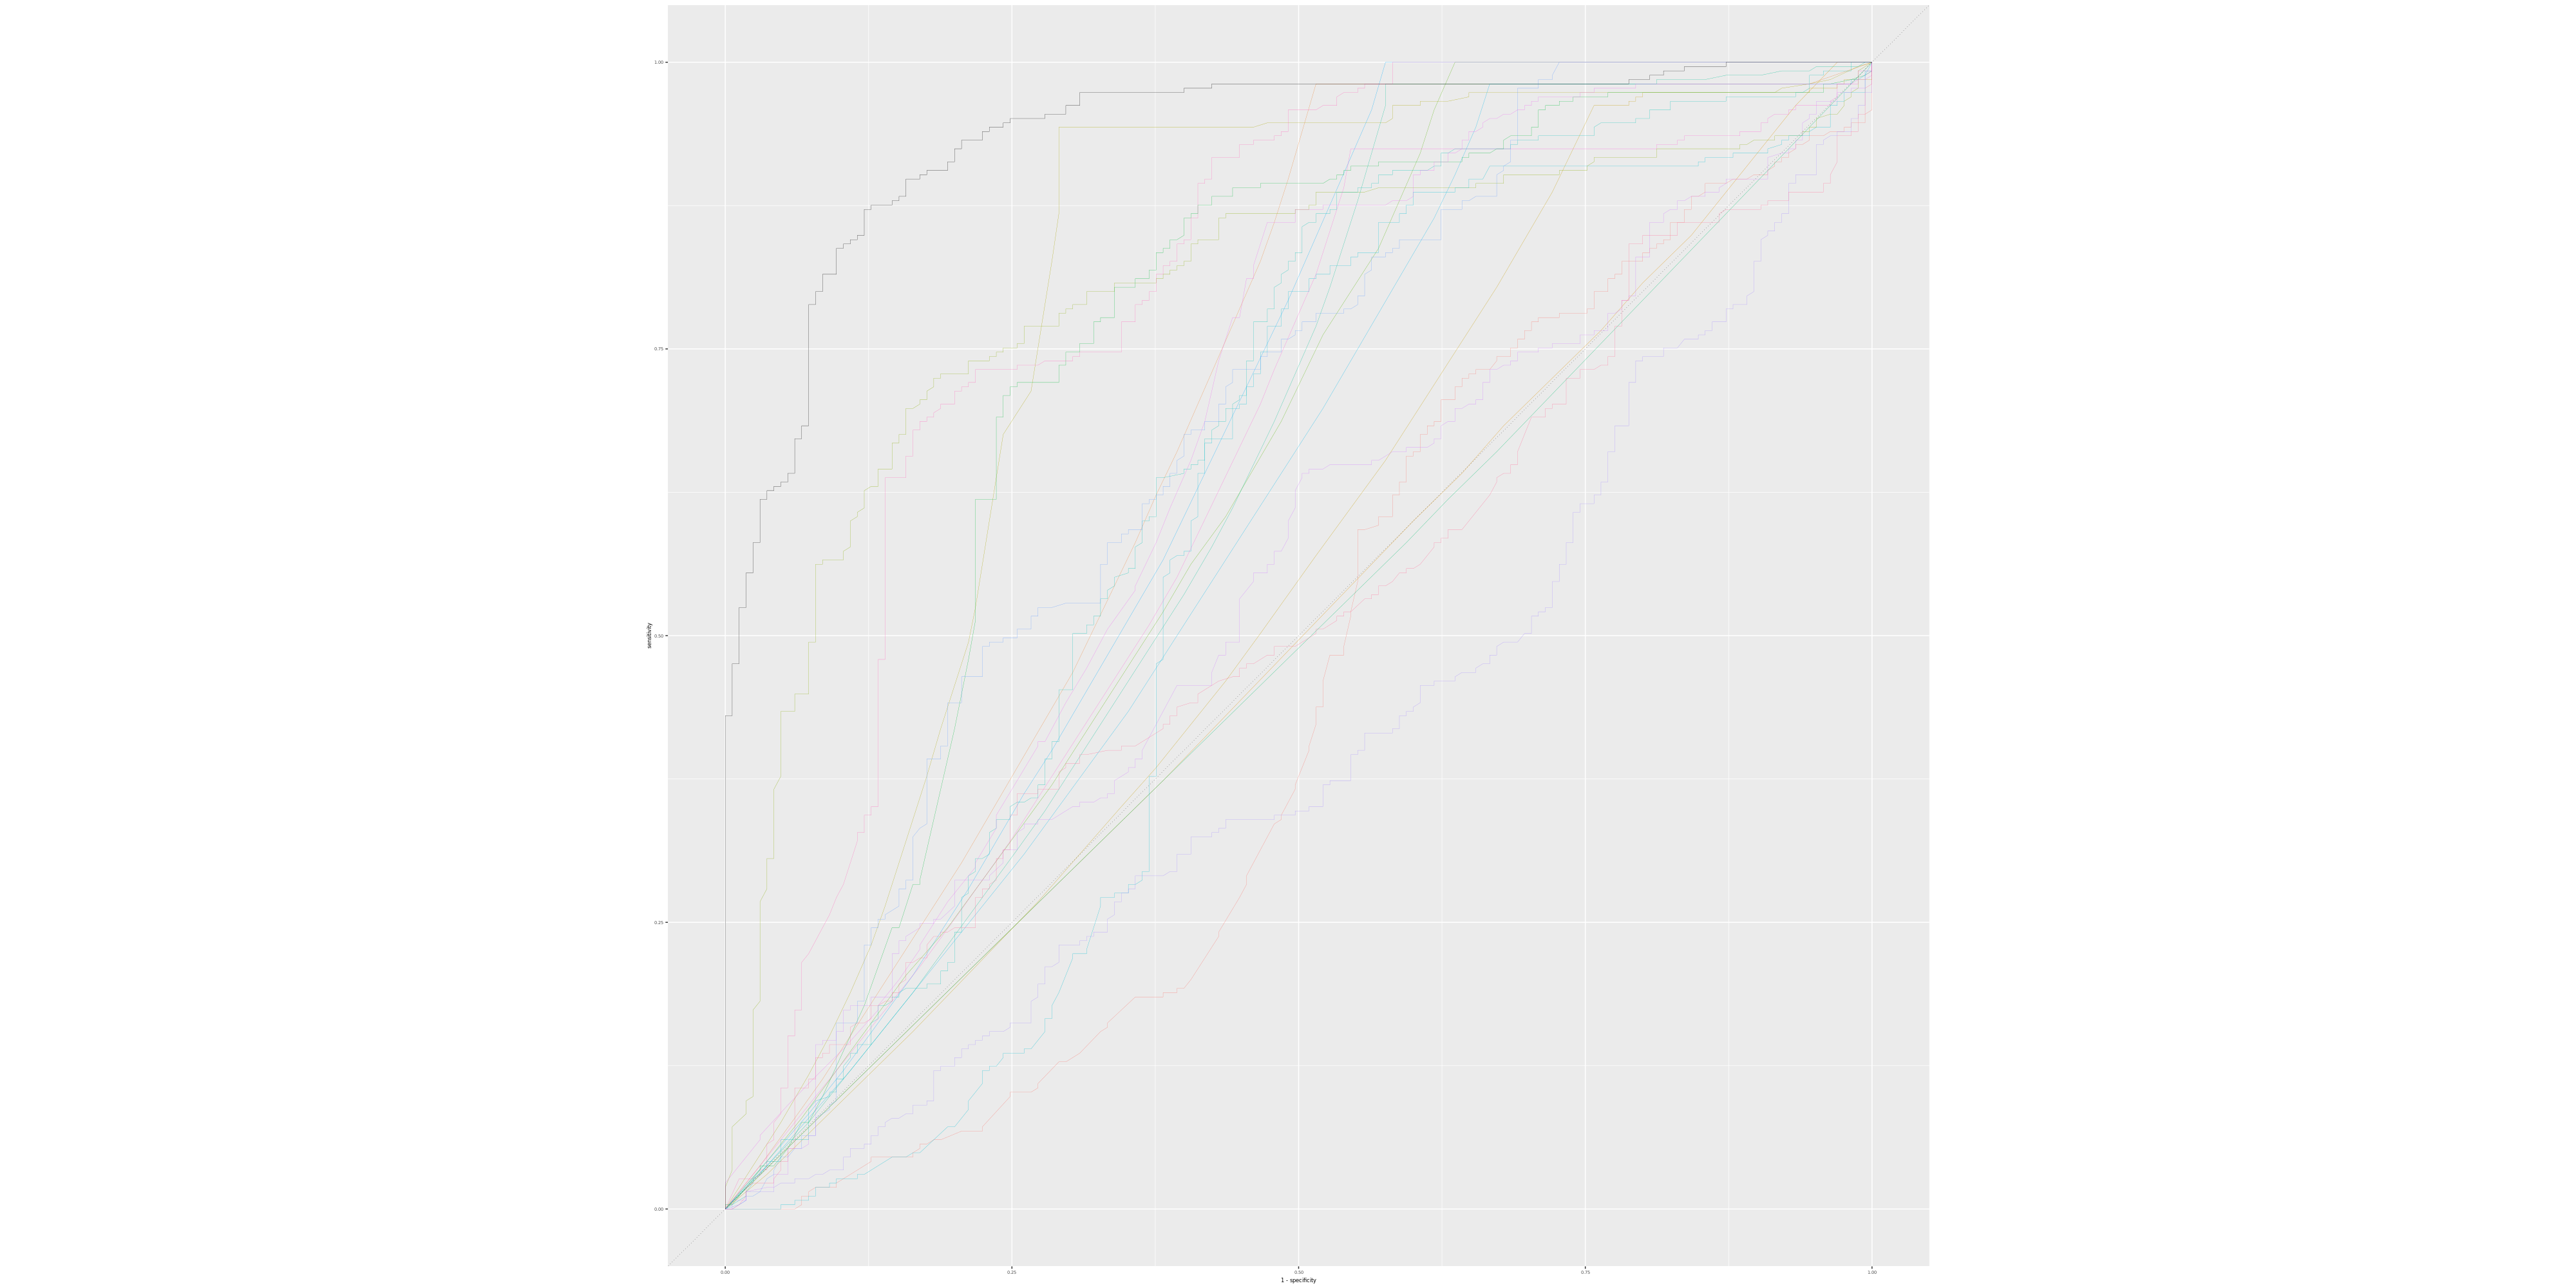

In [21]:
#getting the plots for all individual genes Figure 3 panel A which are CRC samples
plot=roc_data_crc%>%
ggplot(aes(x = 1 - specificity, y = sensitivity, color = Genes)) +
geom_path(lwd=.098) +
geom_abline(lty = 3, lwd=.099)+theme(text = element_text(size=6), aspect.ratio=1)

options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)


plot_CRC_ROC=plot+geom_path(data=allGenesCombinedROC_CRC, aes(x= 1 - specificity, y= sensitivity), 
                    color="black", lwd=.098)


plot_CRC_ROC=plot_CRC_ROC+theme(legend.position = "none")
print(plot_CRC_ROC)




ggsave(filename="Graphs/Roc_top_20_CRC.png", dpi=300, width = 15, height = 15, bg = "white")

In [22]:
###Performing classification analysis to build the ROC curves Figure 3 panel B Which is AA samples 

#Which groups to compare
#normalized
subsetData = foldExpression_wide %>% filter(foldExpression_wide[, 1] %in% c("AA", "Col_Neg", "CON")) 



table(subsetData[, 1])



#getting ROC results for first gene
results=runCrossValidation(subsetData[, c(1, 2)],  controlGroup = c("Col_Neg", "CON"), 
                           numberFolds=5, repeats=5, nameSampleLabelsColumn="Sample_Type")
allPred=collect_predictions(results) %>% mutate(Genes = colnames(subsetData)[2])


#getting ROC results for rest of genes 
averageResults=rep(0, 50)
#for(i in 1:50){
for(i in 3:ncol(subsetData)){

    results=runCrossValidation(subsetData[, c(1, i)],  controlGroup = c("Col_Neg", "CON"), 
                               numberFolds=5, repeats=5, nameSampleLabelsColumn="Sample_Type")
    
    allPred=bind_rows(allPred, collect_predictions(results) %>% mutate(Genes = colnames(subsetData)[i]))
    
}

#Getting the performanc of all genes combined
results=runCrossValidation(subsetData, controlGroup = c("Col_Neg", "CON"), 
                           numberFolds=5, repeats=5, nameSampleLabelsColumn="Sample_Type")

allGenesCombined=collect_predictions(results)
allGenesCombinedROC=allGenesCombined %>% roc_curve(Sample_labels, .pred_Control)


#getting roc data for all individual genes
roc_data=allPred %>% group_by(Genes) %>% roc_curve(Sample_labels, .pred_Control)

#geting roc data for combination of all genes
allGenesCombinedROC=allGenesCombined %>% roc_curve(Sample_labels, .pred_Control)





     AA Col_Neg     CON 
     28      18      35 

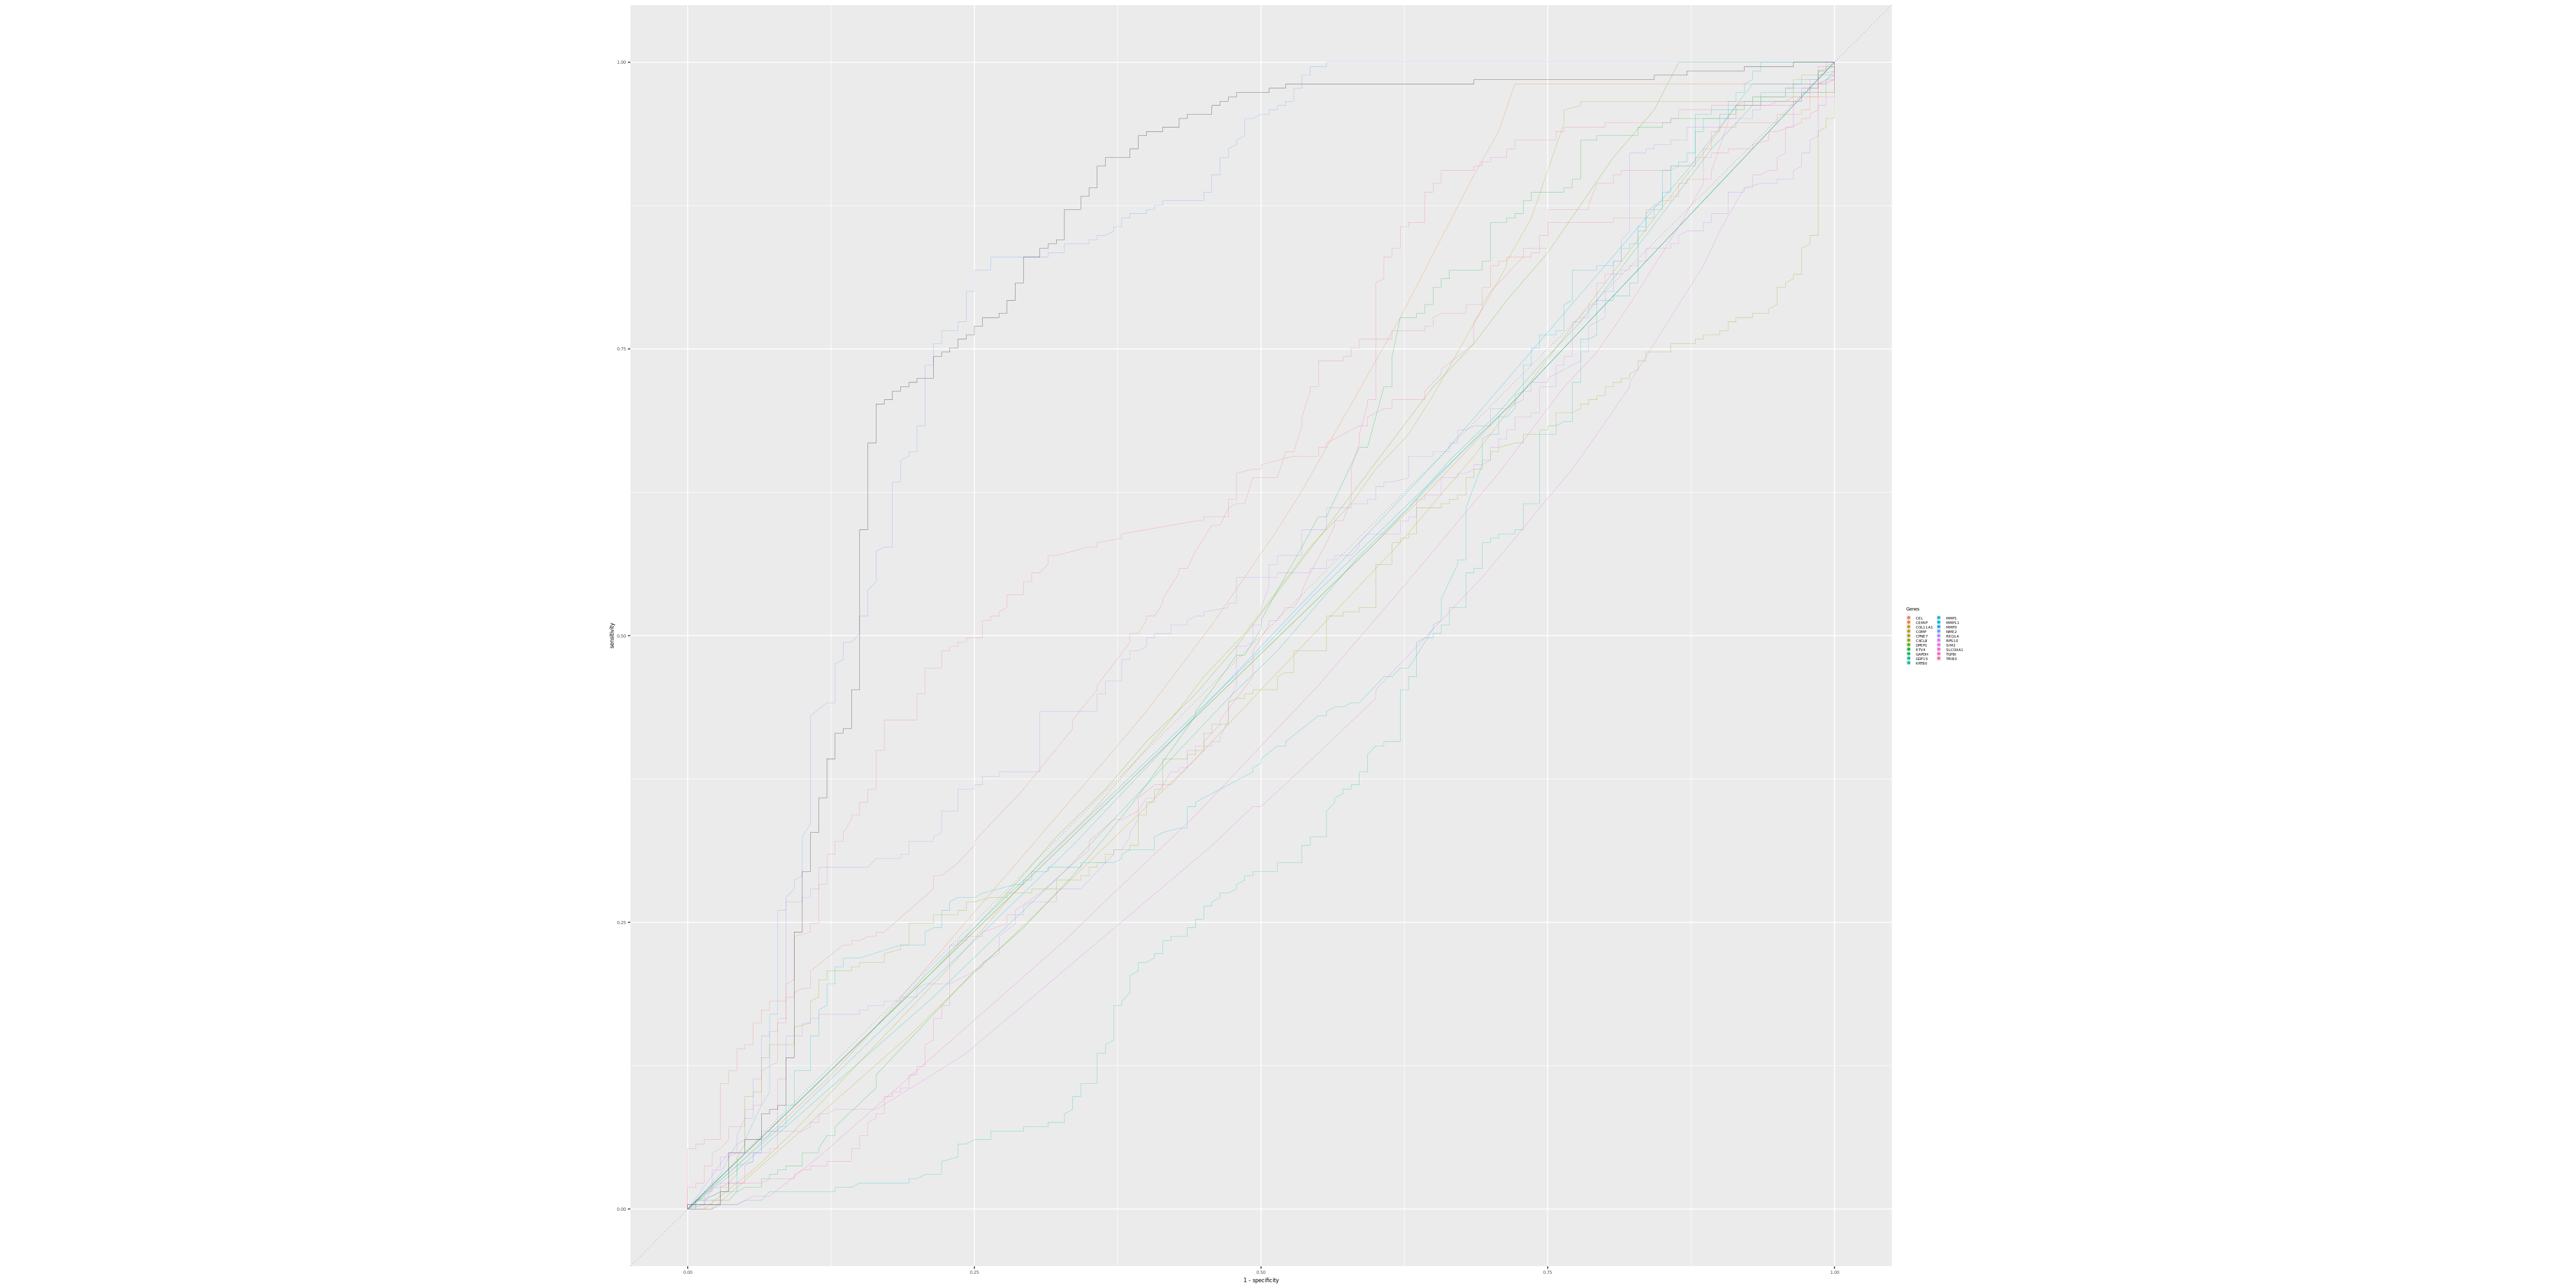

In [23]:
#getting the plots for all individual genes Figure 3 panel B which are AA samples
plot=roc_data%>%
ggplot(aes(x = 1 - specificity, y = sensitivity, color = Genes)) +
geom_path(lwd=.098) +
geom_abline(lty = 3, lwd=.099)+theme(text = element_text(size=6), aspect.ratio=1)


plot_AA_ROC=plot+geom_path(data=allGenesCombinedROC, aes(x= 1 - specificity, y= sensitivity), 
                    color="black", lwd=.098)



plot_AA_ROC=plot_AA_ROC+theme(legend.title = element_text(size=5),
                              legend.text = element_text(size=4), legend.key.size=unit(.07, "in"),
                             legend.key.width=unit(.07, "in"))+geom_point(size=-1)+guides(colour = guide_legend(override.aes = list(size=1,linetype=0)))


print(plot_AA_ROC)




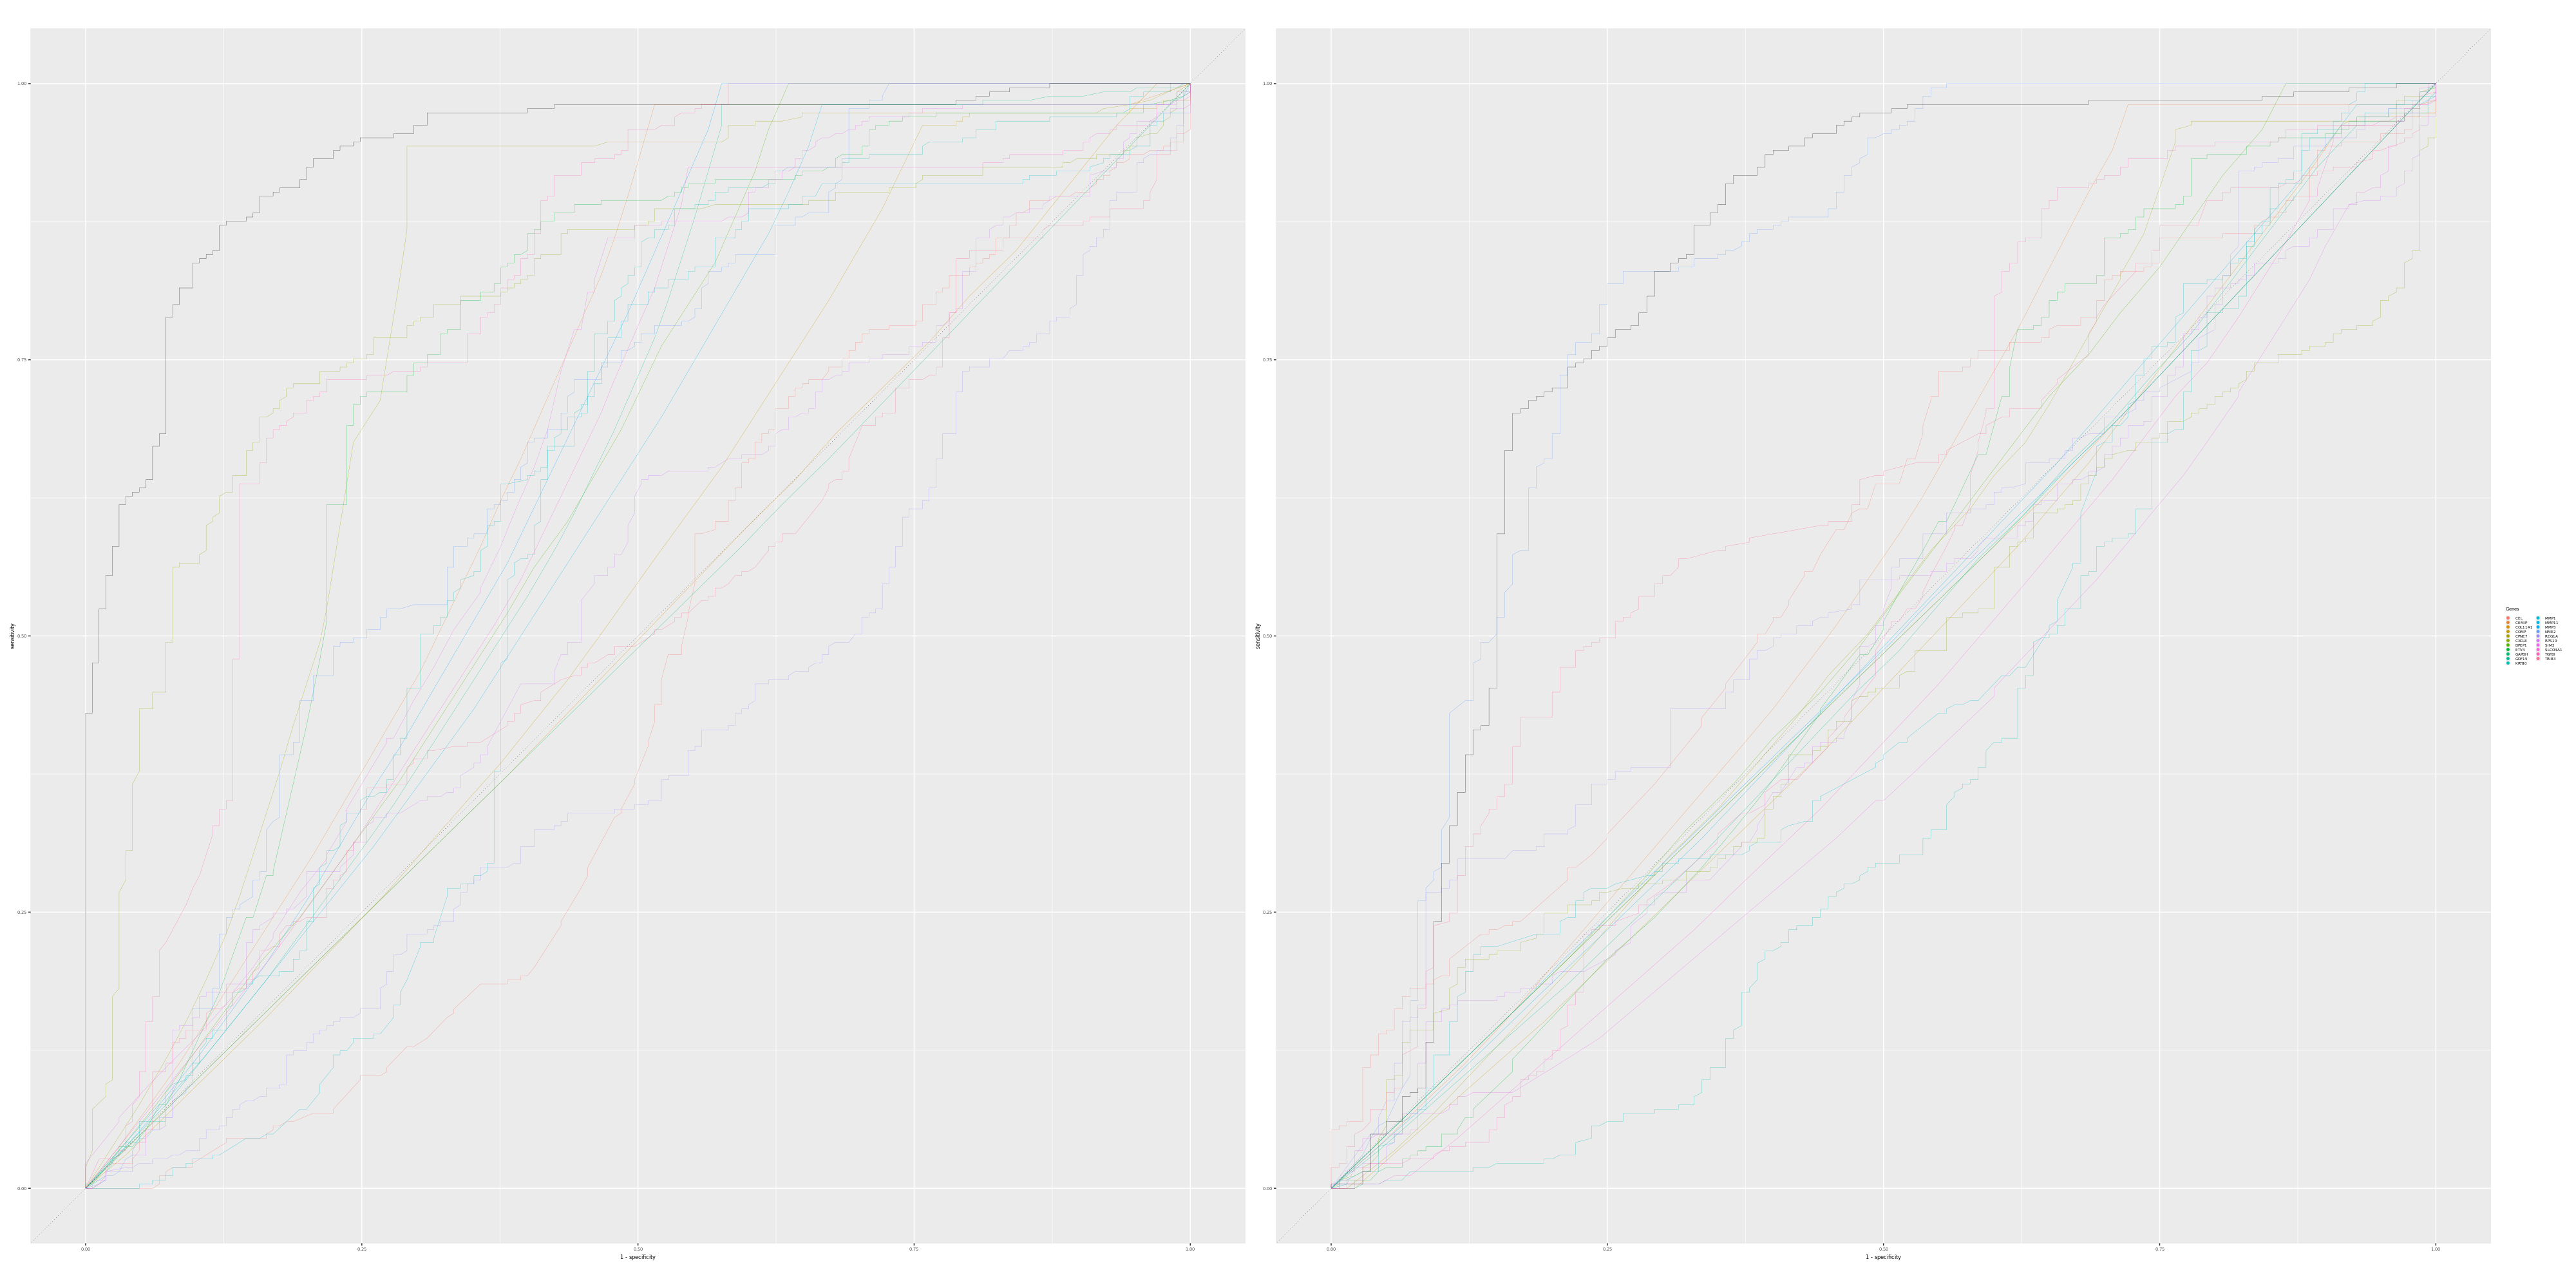

In [24]:
combined_ROC=plot_CRC_ROC|plot_AA_ROC


print(combined_ROC)

ggsave(filename="Graphs/Fig3.pdf", dpi=300, width = 6.6, height = 3.3, bg = "white")


In [25]:
#running 100 random cross validation splits to get average results Data is for Tables 4 and 5 CRC samples normalized data is used


###Adding in stage information to calculate performance by stage

dataSet=cbind("Stage"=All_Genes_data$Stage, foldExpression_wide)


###Setting the number of times to run cross validation using different random splits of the data and take the a average
numberRuns=100


#normalized
subsetData = dataSet %>% filter(dataSet[, "Sample_Type"] %in% c("CRC", "Col_Neg", "CON")) 


head(subsetData)

CrossV_Results=data.frame("Genes_Used"=c(colnames(subsetData)[4:ncol(subsetData)], "Combined_Genes"), 
                          "AUC"=rep(NA, ncol(subsetData)-2), 
                          "Sensitivity"=rep(NA, ncol(subsetData)-2), 
                          "Specificity"=rep(NA, ncol(subsetData)-2))


for(i in 4:ncol(subsetData)){
    
    results=runCrossValidation(subsetData[, c(2, i)],  controlGroup = c("Col_Neg", "CON"),
                               numberFolds=5, repeats=10, nameSampleLabelsColumn="Sample_Type")


    
    temp=collect_metrics(results)

    CrossV_Results$AUC[i-2]=temp$mean[1]
    CrossV_Results$Sensitivity[i-2]=temp$mean[2]
    CrossV_Results$Specificity[i-2]=temp$mean[3]
    
}    

#getting results for all biomarkers
results=runCrossValidation(subsetData[, c(2, 4:ncol(subsetData))], controlGroup = c("Col_Neg", "CON"),
                               numberFolds=5, repeats=numberRuns, nameSampleLabelsColumn="Sample_Type")
temp=collect_metrics(results)

CrossV_Results$AUC[nrow(CrossV_Results)]=temp$mean[1]
CrossV_Results$Sensitivity[nrow(CrossV_Results)]=temp$mean[2]
CrossV_Results$Specificity[nrow(CrossV_Results)]=temp$mean[3]

CrossV_Results
    

 

,Stage,Sample_Type,GAPDH,TGFBI,RPS10,CEMIP,SLCO4A1,MMP11,GDF15,ETV4,NME2,COL11A1,TRIB3,SIM2,MMP3,MMP1,CXCL8,REG1A,KRT80,CEL,COMP,DPEP1,CPNE7
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,III,CRC,1,1.46408570,0.8066418,0.5664419,2.639016,0.1855654,1.2613774,0.5783441,0.4444213,0,1.404445,0.7578583,1.790050,2.32946717,11.00433455,0.21613431,0.05632815,27.8576180,1.068065,2.1734697,2.557971
2,I,CRC,1,1.00000000,0.5000000,0.1593201,0.000000,0.6925547,0.7095617,0.6597540,0.2116863,0,1.109569,0.4263174,0.000000,1.00000000,1.43395525,0.08304286,0.06934809,1.7171309,0.000000,0.0000000,3.543070
3,III,CRC,1,2.63901582,24.5900029,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,7.5161820,0,0.000000,19.6983106,0.000000,0.00000000,0.13773814,6.36429187,67.64915460,182.2784250,0.000000,0.0000000,11.917420
4,III,CRC,1,6.02098699,1.8025009,4.6589343,9.646463,5.4264173,1.6643975,4.9588308,1.0000000,0,4.084049,0.0000000,1.464086,1.61328352,3.22656704,2.98969850,1.14869835,8.1116758,0.000000,3.5801003,46.045875
5,I,CRC,1,0.37631169,0.4322686,1.0792282,1.717131,0.0000000,1.1607039,1.2483305,1.9052760,0,5.696201,25.4571675,0.000000,0.45375958,17.87659421,1.28342590,5.50216727,1.8531761,0.000000,0.0000000,13.041157
6,II,CRC,1,0.05006687,1.0281138,0.0000000,1.000000,0.0000000,0.3426957,0.0000000,0.1830107,0,0.000000,0.4569157,0.000000,0.03280365,0.05751173,0.14458602,0.38689125,0.8705506,0.000000,0.1339717,0.000000


Genes_Used,AUC,Sensitivity,Specificity
<chr>,<dbl>,<dbl>,<dbl>
TGFBI,NA,NA,NA
RPS10,0.8236104,0.62190476,0.8230909
CEMIP,0.5892359,0.36285714,0.7532727
SLCO4A1,0.7314134,0.48619048,0.9812727
MMP11,0.6813615,0.42761905,0.9240000
GDF15,0.6408139,0.30476190,0.9810909
ETV4,0.6961818,0.42619048,0.9703636
NME2,0.7742532,0.59142857,0.8183636
COL11A1,0.6846299,0.47190476,0.7745455


In [26]:
###Getting the performance broken down by stage

CRC_predictions=collect_predictions(results)
CRC_predictions$Label_Breakdown=subsetData$Sample_Type[CRC_predictions$.row]
CRC_predictions$Stage=subsetData$Stage[CRC_predictions$.row]


##initilizing results data frame
resultsByStage=data.frame("Stage"=rep(NA, 4), 
                          "Sensitivity"=rep(NA, 4), 
                          "Number_Samples"=rep(NA, 4), 
                           "Specificity"=rep(CrossV_Results[nrow(CrossV_Results), "Specificity"], ))



stages=c("I", "II", "III", "IV")

table(All_Genes_data$Stage)

for(i in 1:length(stages)){

    stage=stages[i]
    
    indexes=which(CRC_predictions$Stage==stage)

    TP=length(which(CRC_predictions[indexes, ".pred_Disease"]>0.5))
    total=length(indexes)

    sens=TP/total

    resultsByStage$Stage[i]=stage
    resultsByStage$Sensitivity[i]=sens
    resultsByStage$Number_Samples[i]=(total/numberRuns)
}

resultsByStage



   I   II  III   IV none 
   9    8   11    4    1 

Stage,Sensitivity,Number_Samples,Specificity
<chr>,<dbl>,<dbl>,<dbl>
I,0.5122222,9,0.9512182
II,0.7850000,8,0.9512182
III,0.7590909,11,0.9512182
IV,1.0000000,4,0.9512182


In [27]:
#running 100 random cross validation splits to get average results Data is for Tables 4 and 5 AA samples


#Which groups to compare
#normalized
subsetData = foldExpression_wide %>% filter(foldExpression_wide[, 1] %in% c("AA", "Col_Neg", "CON")) 


CrossV_Results=data.frame("Genes_Used"=c(colnames(subsetData)[3:ncol(subsetData)], "Combined_Genes"), 
                          "AUC"=rep(NA, ncol(subsetData)-1), 
                          "Sensitivity"=rep(NA, ncol(subsetData)-1), 
                          "Specificity"=rep(NA, ncol(subsetData)-1))



for(i in 3:ncol(subsetData)){
    results=runCrossValidation(subsetData[, c(1, i)],  controlGroup = c("Col_Neg", "CON"),
                               numberFolds=5, repeats=10)

    temp=collect_metrics(results)

    CrossV_Results$AUC[i-2]=temp$mean[1]
    CrossV_Results$Sensitivity[i-2]=temp$mean[2]
    CrossV_Results$Specificity[i-2]=temp$mean[3]
    
}    

#getting results for all biomarkers
results=runCrossValidation(subsetData, controlGroup = c("Col_Neg", "CON"),
                               numberFolds=5, repeats=100)
temp=collect_metrics(results)

CrossV_Results$AUC[nrow(CrossV_Results)]=temp$mean[1]
CrossV_Results$Sensitivity[nrow(CrossV_Results)]=temp$mean[2]
CrossV_Results$Specificity[nrow(CrossV_Results)]=temp$mean[3]

CrossV_Results
    

 

Genes_Used,AUC,Sensitivity,Specificity
<chr>,<dbl>,<dbl>,<dbl>
TGFBI,0.5897212,0.37533333,0.8618182
RPS10,0.4428909,0.15666667,0.7212727
CEMIP,0.6260909,0.27200000,0.9810909
SLCO4A1,0.5152606,0.08266667,0.9607273
MMP11,0.5157879,0.05066667,0.9809091
GDF15,0.5006061,0.03466667,0.9625455
ETV4,0.5535818,0.30466667,0.8409091
NME2,0.8221818,0.53733333,0.8996364
COL11A1,0.5000000,0.00000000,1.0000000


In [28]:
##Getting counts data into a form that is suitable for plotting with ggplot2 this means getting it
##into long format

transposed_cpm_Counts=t(cpm_Counts)


transposed_cpm_Counts=transposed_cpm_Counts[-1, ]

transposed_cpm_Counts=as.data.frame(transposed_cpm_Counts)

##removing number after disease label
transposed_cpm_Counts=cbind("Sample_Type"=gsub("\\..*","",rownames(transposed_cpm_Counts)), transposed_cpm_Counts)

colnames(transposed_cpm_Counts)=transposed_cpm_Counts[1, ]
transposed_cpm_Counts=transposed_cpm_Counts[-1, ]
colnames(transposed_cpm_Counts)[1]="Sample_Type"

#remove duplicated columns
transposed_cpm_Counts <- transposed_cpm_Counts[!duplicated(as.list(transposed_cpm_Counts))]

#convert to long format
cpm_long=gather(transposed_cpm_Counts, Genes, CPM, 2:ncol(transposed_cpm_Counts), factor_key=TRUE)

#make sure cpm column is numeric
cpm_long <- cpm_long %>% mutate_at(3, as.numeric)

head(cpm_long)

,Sample_Type,Genes,CPM
,<chr>,<fct>,<dbl>
1,T,TSPAN6,477.2524
2,T,TSPAN6,202.3646
3,T,TSPAN6,40.2303
4,T,TSPAN6,177.9384
5,T,TSPAN6,282.0250
6,T,TSPAN6,580.2178


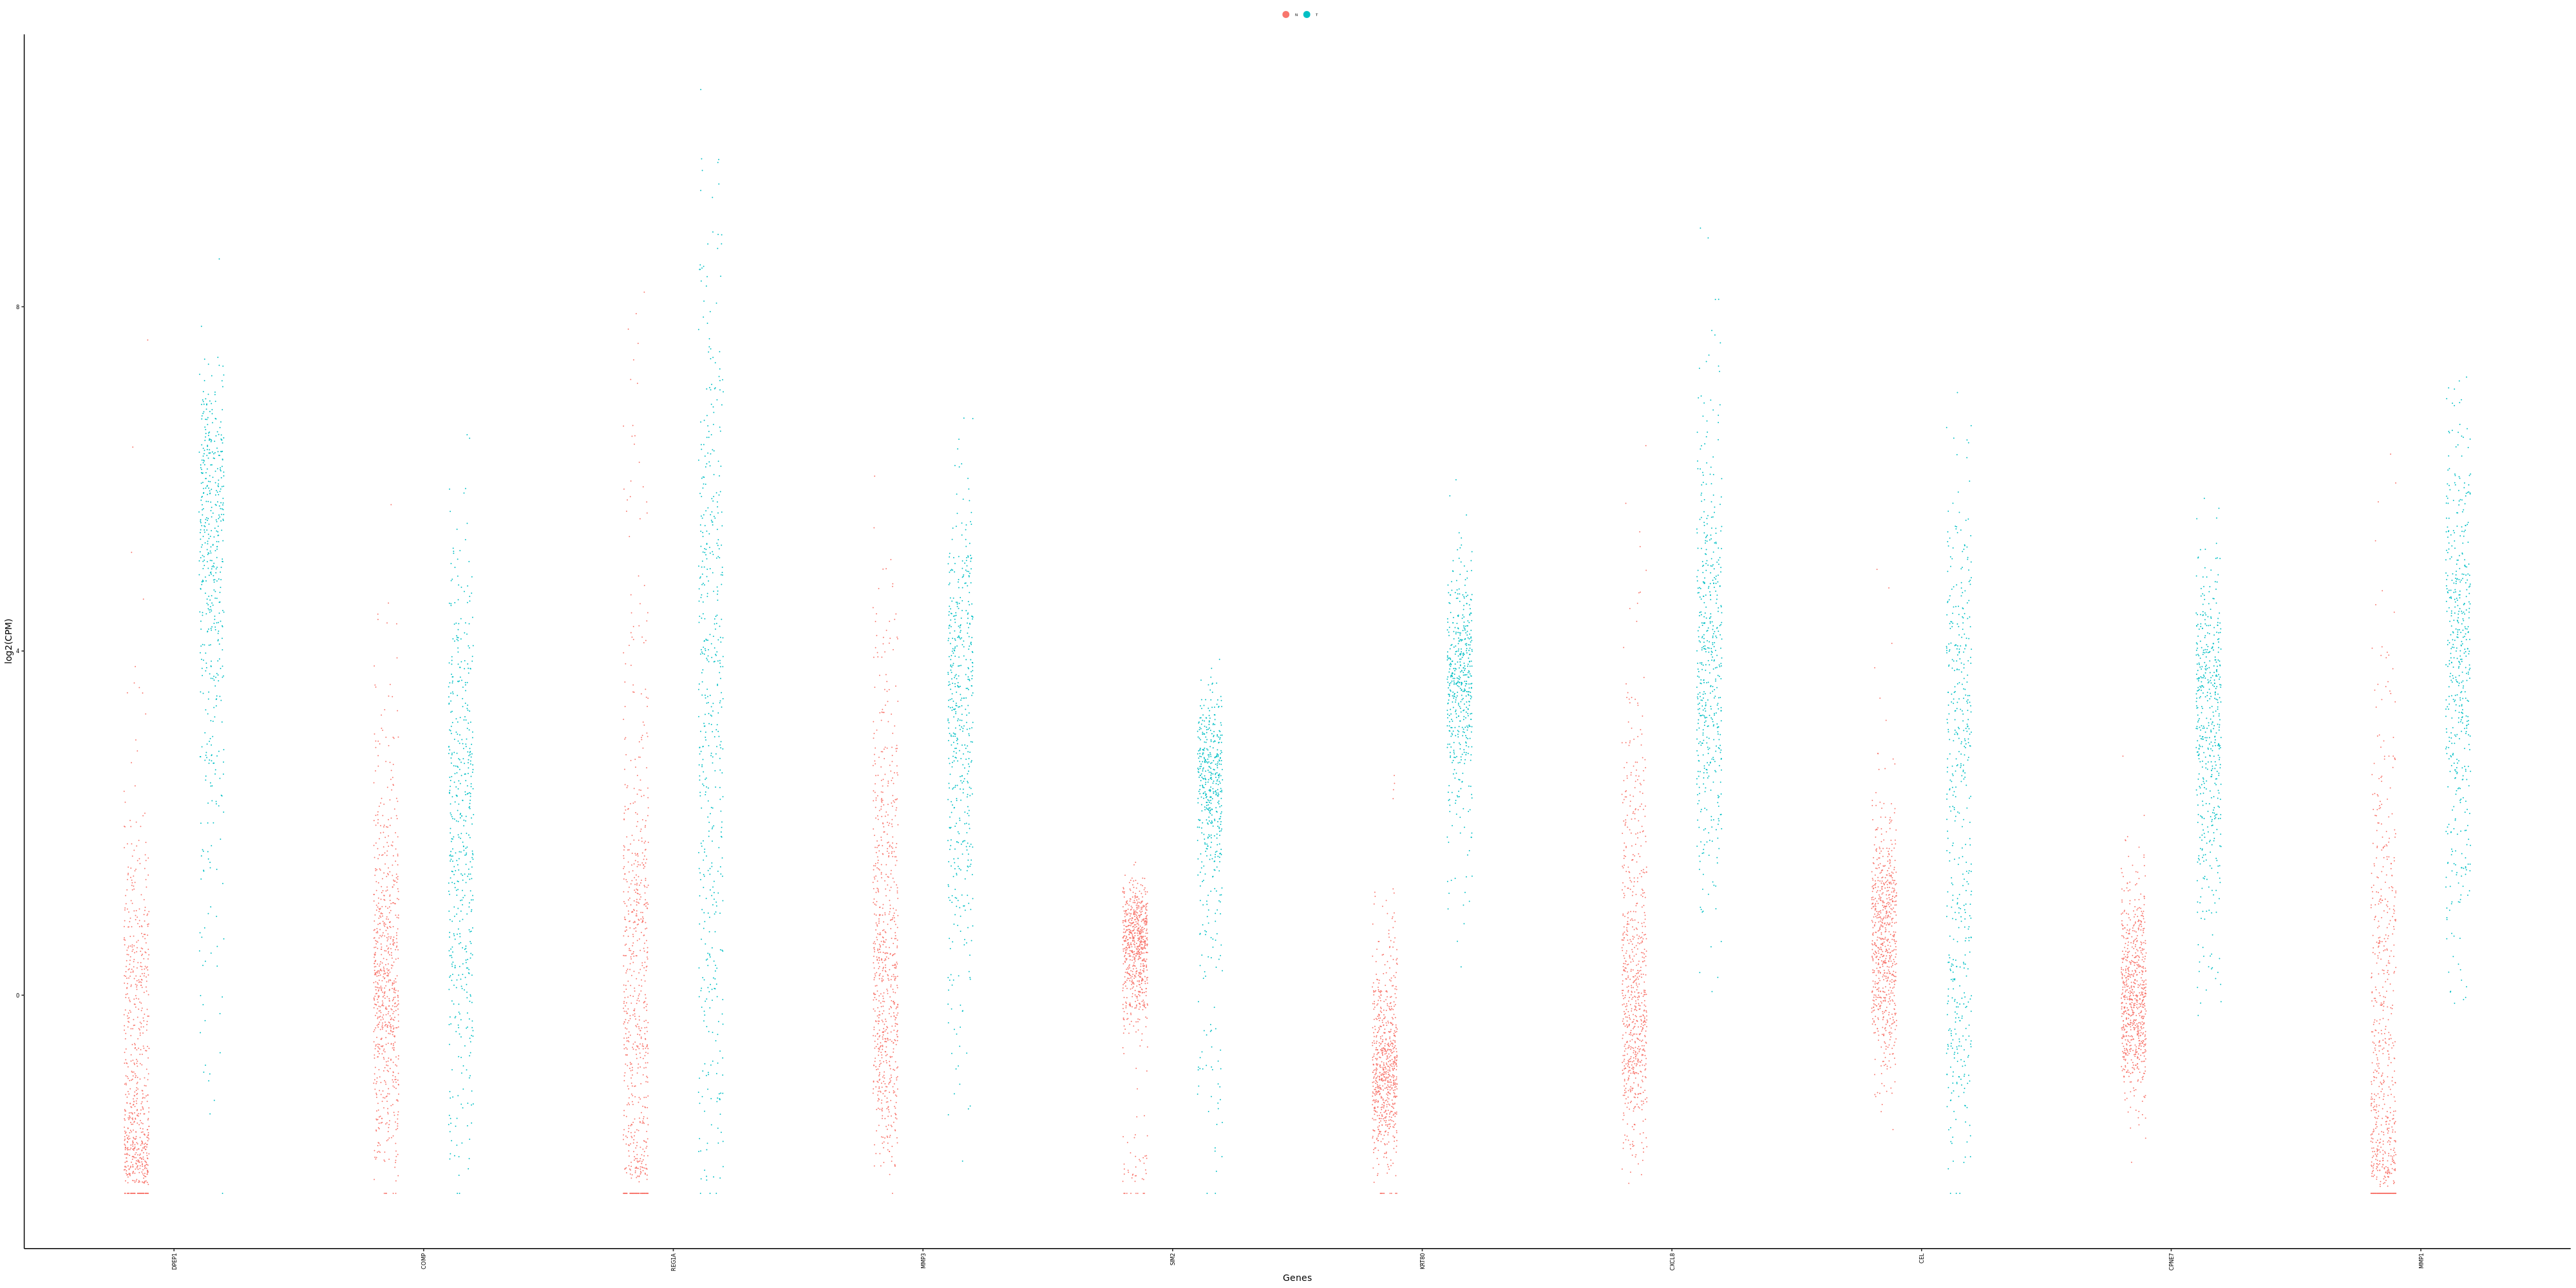

In [29]:
####Plotting genes tissue expression CPM values (Will be Supplemental Figure 1) 
###plotting the low background gene list

####getting the low background gene list
geneNames=c(top_low_background_list)


####CPM 
expressionSubset=cpm_long %>% filter(Genes %in% geneNames[1:length(geneNames)])

temp=which(expressionSubset$Sample_Type %in% c("Gtex_N", "TCGA_N"))
expressionSubset$Sample_Type[temp]="N"


###taking the log
expressionSubset$CPM=log(expressionSubset$CPM+0.1)


options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)



###Plot each point
    plot=ggplot(expressionSubset, aes(x=Genes, y=CPM, color=Sample_Type))+
    geom_point(position = position_jitterdodge(seed = 1, dodge.width = 0.6,  jitter.width=0.1), size=0, 
                           aes(color=Sample_Type))+theme_pubr()+
theme(text = element_text(size=10), legend.title = element_text(size=6), legend.text = element_text(size=4), legend.key.size = unit(0.07, 'in'))+guides(color = guide_legend(override.aes = list(size = 3)))+labs(x = "Genes", y = "log(CPM)", color = "")+
theme(text = element_text(size=10), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=6), 
      axis.text.y = element_text(size=6), axis.title=element_text(size=10))+labs(y="log2(CPM)")


             

print(plot)



     

###Boxplot Version

 # plot1=ggplot(expressionSubset, aes(x=Genes, y=CPM, color=Sample_Type))+geom_boxplot(lwd=0.5)+
  #  geom_point(position = position_jitterdodge(seed = 1, dodge.width = 0.6,  jitter.width=0.1), size=1, 
   #                        aes(color=Sample_Type))+theme_pubr()+theme(text = element_text(size=45), axis.text.x = 
    #                                                                         element_text(angle = 90, vjust = 0.5, 
     #                                                                                 hjust=1, size=45), axis.title.x = element_text(margin = margin(t = 30))) 

    #plot1=plot1+theme(legend.text = element_text(size=30), legend.title=element_text(size=30), legend.key.width = unit(5, 'cm') )

  
    
#adding a title    
 #plot1=plot1+ggtitle(mainTitle)+stat_compare_means(size=10, method="wilcox", comparisons=list(rep(c("CRC", "Control"), length(unique(data_long$Genes)))), hide.ns=TRUE)


  #  plot1=plot1+ggtitle("Low Background Genes Expression in Tissue") #+stat_compare_means(size=15, method="wilcox", label.y=yLocationPValue, hide.ns=TRUE, label="p.format")


#print(plot)




##Saving plots as pngs 
ggsave(filename="Graphs/Supplemental_Figure1_Tissue_low_background.png", dpi=300, width = 30,   height = 15, bg = "white")



In [30]:
###Saving the plot is a form that is suitable for the journal


ggsave(filename="Graphs/supp_Fig1.pdf", dpi=300, width = 6.6, height = 3.3, bg = "white")


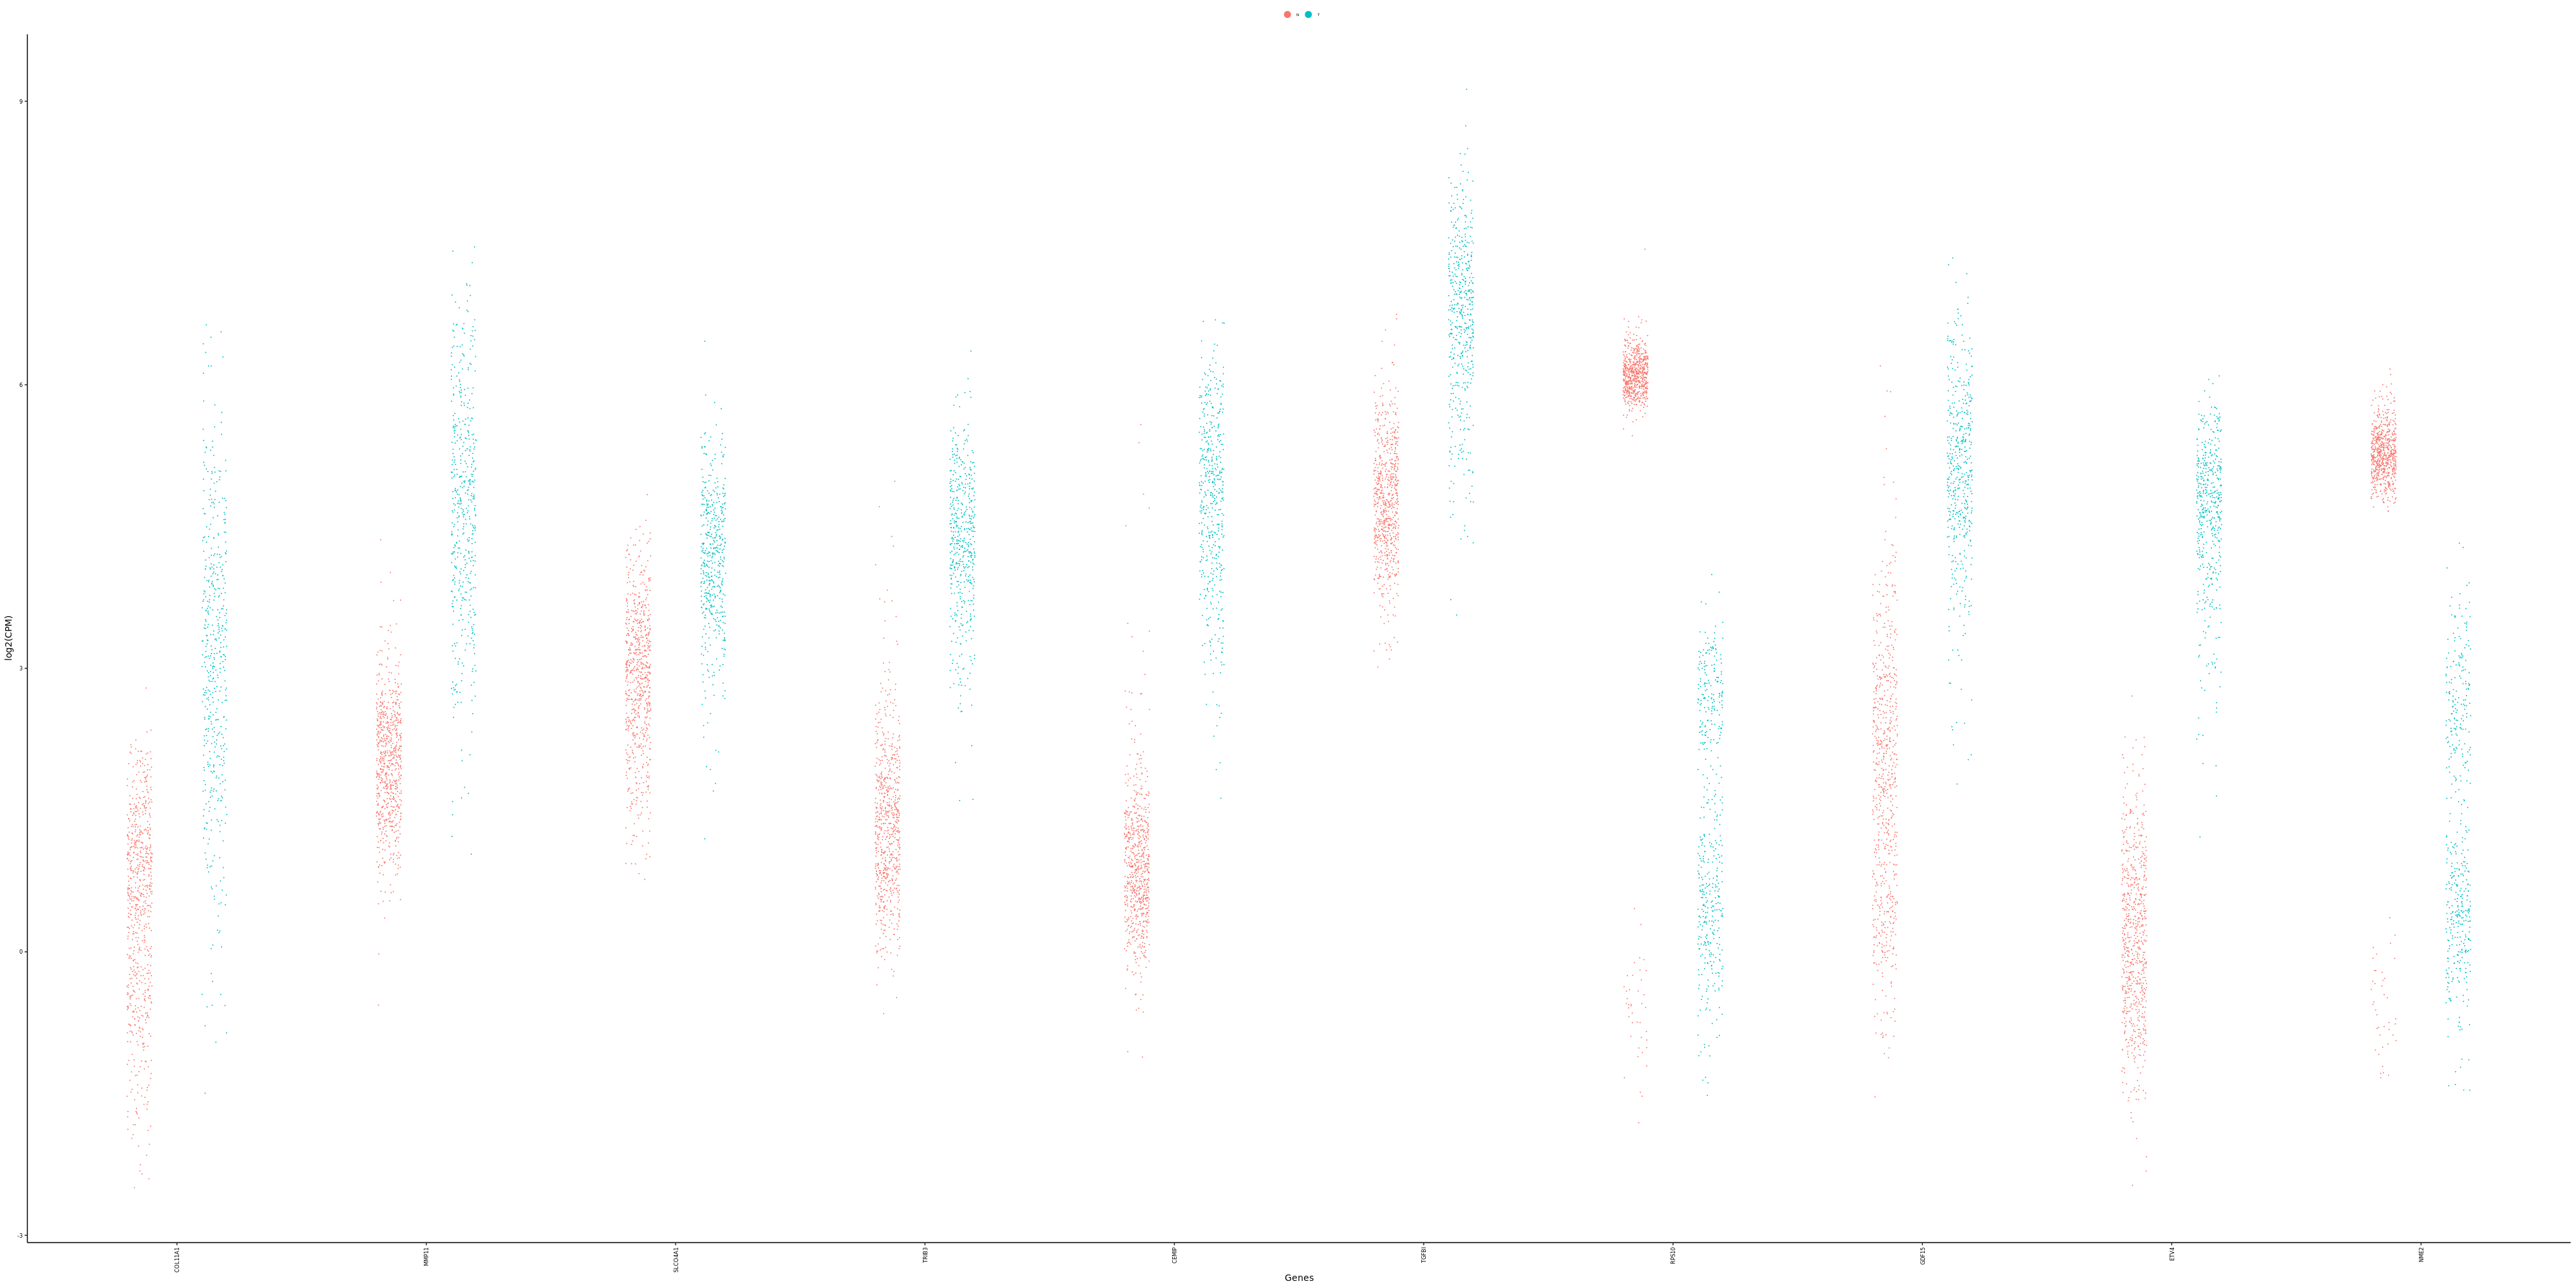

In [31]:
####Plotting genes tissue expression CPM values (Will be Supplemental Figure 2) 
###plotting the high CRC gene list

####getting the high CRC gene list
geneNames=c(top_high_CRC_list)


####CPM 
expressionSubset=cpm_long %>% filter(Genes %in% geneNames[1:length(geneNames)])



temp=which(expressionSubset$Sample_Type %in% c("Gtex_N", "TCGA_N"))
expressionSubset$Sample_Type[temp]="N"


###taking the log
expressionSubset$CPM=log(expressionSubset$CPM)

options(repr.plot.width = 40, repr.plot.height = 20, repr.plot.res = 100)


###Plot each point
 #   plot=ggplot(expressionSubset, aes(x=Genes, y=CPM, color=Sample_Type))+
 #   geom_point(position = position_jitterdodge(seed = 1, dodge.width = 0.6,  jitter.width=0.1), size=0, 
  #                         aes(color=Sample_Type))+theme_pubr()+
#theme(text = element_text(size=10), legend.title = element_text(size=6), legend.text = element_text(size=4), legend.key.size = unit(0.07, 'in'))+
#guides(color = guide_legend(override.aes = list(size = 3)))+labs(x = "Genes", y = "log(CPM)", color = "")+
#theme(text = element_text(size=10), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=6), 
 #     axis.text.y = element_text(size=6), axis.title=element_text(size=10))


             


#print(plot)




###Plot each point
    plot=ggplot(expressionSubset, aes(x=Genes, y=CPM, color=Sample_Type))+
    geom_point(position = position_jitterdodge(seed = 1, dodge.width = 0.6,  jitter.width=0.1), size=0, 
                           aes(color=Sample_Type))+theme_pubr()+
theme(text = element_text(size=10), legend.title = element_text(size=6), legend.text = element_text(size=4), legend.key.size = unit(0.07, 'in'))+guides(color = guide_legend(override.aes = list(size = 3)))+labs(x = "Genes", y = "log(CPM)", color = "")+
theme(text = element_text(size=10), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=6), 
      axis.text.y = element_text(size=6), axis.title=element_text(size=10))+labs(y="log2(CPM)")


             

print(plot)




##Saving plots as pngs 
#ggsave(filename="Graphs/Supplemental_Figure2_Tissue_high_crc.png", dpi=300, width = 30,   height = 15, bg = "white")



In [32]:

ggsave(filename="Graphs/supp_Fig2.pdf", dpi=300, width = 6.6, height = 3.3, bg = "white")
